# Example for:
Transfer Learning Empirical Experiment from Classes: [5, 6, 7, 8, 9](pretraining) to classes:[2, 3, 0, 1] (finetuning) of CIFAR (Random experiment)

### Setup and Hyperparams

In [1]:
# Specify which gpu
import os
gpu_id = 3
# os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)

import sys
sys.path.append('/home/arnisaf/mp-tl-study')
from functions.utils import *

# device = torch.device("cuda" if torch.cuda.is_available() else "mps")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)
    torch.cuda.manual_seed_all(0)  # if using multi-GPU

In [2]:
# cuts=0 means: end-to-end model if we are reinitializing
cuts = [0,1,2,3,4,5]

In [3]:
# Changes Here for the experiments
params = {
      # MODEL ARCHITECTURE PARAMS
      'depth': 6,
      'num_channels': 64, # num channels for CNN
      # 'hidden_dim_lin': 128,
      'activation_function': nn.ReLU,
      'kernel_size': 3,
      # TRAINING PARAMS
      'device': device,
      'lr_pretrain': 0.001,   
      'lr_fine_tune': 0.001,  # CHANGE: if no layer-wise lr
      # 'lr_fine_tune_reinit': 0.001,         # CHANGE: if no layer-wise lr
      # 'lr_fine_tune_no_reinit': 0.0001,     # CHANGE: if layer-wise lr
      'num_train': 10,
      'early_stop_patience': 5,
      'save_best': False,
      'save_checkpoints': False,
      'is_cnn': True,
      'is_debug': False,
      'classification_report_flag': False,
      'batch_size':64,
      # DATASET PARAMS
      'pre_train_classes': [5, 6, 7, 8, 9], # [0, 1, 8, 9] are animals 
      'fine_tune_classes': [2, 3, 0, 1], # [2, 3, 4, 5, 6, 7] are vehicles 
        'val_split': 0.1,
      'num_workers': 0,
      'generate_dataset_seed': 42,
      # EXPERIMENT SETTING PARAMS
      'use_pooling': True,   # CHANGE
      'pooling_every_n_layers': 2, # add pooling after every n layers specified here. For only one pooling after all the CNN layers, this equals params['depth']
      'pooling_stride': 2,
      'freeze': True,         # CHANGE: freeze the conv layers before the cut
      'reinit': True,         # CHANGE: reinit the conv lyers only after the cut
      'reinit_both_dense': True,   # CHANGE: True for reinitialize both dense layers, False for reinit only the last dense layer
      'truncate': False
    }

In [4]:
root_dir = './data'  # Specify your data directory here
transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
dataloader_wrapped = TransferLearningWrapper(params, datasets.CIFAR10, datasets.CIFAR10, root_dir, transform=transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Pretraining

In [5]:
pretrained_model = CustomCNN(params, dataloader_wrapped.output_dim, tuple(dataloader_wrapped.finetune_test_loader.dataset[0][0].shape))
pretrained_model.to(device)

CustomCNN(
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (pool3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (pool5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc): Linear(in_features=1024, out_features=5, bias=True)
)

In [13]:
# Train and evaluate
trainer = Trainer(pretrained_model, dataloader_wrapped, params["lr_pretrain"], params)
train_acc, test_acc, effective_epochs, checkpoints = trainer.train()

print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")

Epoch: 0 	Training Accuracy: 71.01%
Validation Accuracy: 71.40%
Epoch: 1 	Training Accuracy: 78.06%
Validation Accuracy: 77.40%
Epoch: 2 	Training Accuracy: 81.28%
Validation Accuracy: 79.92%
Epoch: 3 	Training Accuracy: 85.44%
Validation Accuracy: 83.28%
Epoch: 4 	Training Accuracy: 87.00%
Validation Accuracy: 85.72%
Epoch: 5 	Training Accuracy: 89.88%
Validation Accuracy: 87.68%
Epoch: 6 	Training Accuracy: 89.77%
Validation Accuracy: 86.92%
Epoch: 7 	Training Accuracy: 91.00%
Validation Accuracy: 86.92%
Epoch: 8 	Training Accuracy: 93.44%
Validation Accuracy: 88.84%
Epoch: 9 	Training Accuracy: 92.48%
Validation Accuracy: 87.92%
Final Training Accuracy: 0.9248
Final Test Accuracy: 0.8816


In [14]:
# save model
torch.save(pretrained_model.state_dict(), 'modelcifar10_mixed.pth')

In [6]:
pretrained_model.load_state_dict(torch.load('pretrained_models/pretrained_model_mixed_classes/modelcifar10_mixed.pth'))
pretrained_model.to(device)

CustomCNN(
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (pool3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (pool5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc): Linear(in_features=1024, out_features=5, bias=True)
)

In [7]:
eval(pretrained_model, device, dataloader_wrapped.val_loader, debug=True, classification_report_flag=True, is_cnn=True)


Average loss: 0.3366, Accuracy: 2198.0/2500 (88%)

              precision    recall  f1-score   support

     Class 0       0.79      0.86      0.83       489
     Class 1       0.97      0.82      0.89       500
     Class 2       0.85      0.86      0.85       509
     Class 3       0.87      0.97      0.92       522
     Class 4       0.94      0.89      0.91       480

    accuracy                           0.88      2500
   macro avg       0.88      0.88      0.88      2500
weighted avg       0.88      0.88      0.88      2500



0.8792

In [14]:
# save model for later use
torch.save(pretrained_model.state_dict(), 'pretrained_models/pretrained_0.001/pretrained_model_89percent.pth')

params_tmp = copy.deepcopy(params)
del params_tmp["device"]
params_tmp["activation_function"] = str(params_tmp["activation_function"])
#save params as well
with open('pretrained_models/pretrained_0.001/params.json', 'w') as fp:
    json.dump(params_tmp, fp)

## Fine-tuning Experiments

### Baselines (End-to-end models trained on subsets of fine-tuning dataset)
We also reuse the baselines a lot! so skip if we already have the jsons

In [9]:
baselines_results = []
percentages = [0.001, 0.01, 0.1, 0.5, 1.0]

In [20]:
#training of baseline, end to end, models (#trials x #percentages)

dataloader_wrapped.update_phase('finetune')

# template_model = generate_cnn(input_dim = 28, output_dim = 10, depth = params['depth'], num_channels = params['width'],
#                      hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=params['use_pooling'])

for sampled_percentage in percentages:      
    if sampled_percentage <= 0.01:
        repeats = 25
    elif sampled_percentage < 0.5:
        repeats = 20
    else:
        repeats = 5
    
    for repeat in range(repeats):
        # Print or log the sampled values for transparency
        print(f"\nSampled Percentage: {sampled_percentage}, Lr: {params['lr_fine_tune']}, Repeat: {repeat}")

        # Reduce the dataset
        train_loader_reduced = reduce_dataset(dataloader_wrapped.train_loader, sampled_percentage, seed = repeat)
        torch.manual_seed(repeat)
        #train_loader_reduced = reduce_dataset(dataloader_wrapped.train_loader, sampled_percentage, seed = repeat)
        dataset_namespace_new = SimpleNamespace(train_loader=train_loader_reduced, test_loader=dataloader_wrapped.test_loader, val_loader=dataloader_wrapped.val_loader)

        # Copy and then cut the model - we already deepcopy it in the function: pretrained_model
        params_tmp = copy.deepcopy(params)
        params_tmp["reinit"] = True
        model_new = cut_custom_cnn_model(pretrained_model, cut_point=0, params=params_tmp, output_dim=dataloader_wrapped.output_dim)
        model_new.to(device)

        # Train and evaluate
        trainer = Trainer(model_new, dataset_namespace_new, params['lr_fine_tune'], params)
        train_acc, test_acc, effective_epochs, checkpoints = trainer.train(verbose=0)
        print(f"Training Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

        # Store the results
        baselines_results.append({"lr":params['lr_fine_tune'], "sampled_percentage":sampled_percentage, "sampled_cut_point":-1, "repeat":repeat, "train_acc":train_acc, "test_acc":test_acc}) # -1 for the cut point means it's baseline


Sampled Percentage: 0.001, Lr: 0.001, Repeat: 0
Training Accuracy: 0.7500, Test Accuracy: 0.2988

Sampled Percentage: 0.001, Lr: 0.001, Repeat: 1
Training Accuracy: 0.8125, Test Accuracy: 0.3370

Sampled Percentage: 0.001, Lr: 0.001, Repeat: 2
Early stopping invoked.
Training Accuracy: 0.5000, Test Accuracy: 0.2908

Sampled Percentage: 0.001, Lr: 0.001, Repeat: 3
Early stopping invoked.
Training Accuracy: 0.6250, Test Accuracy: 0.3850

Sampled Percentage: 0.001, Lr: 0.001, Repeat: 4
Early stopping invoked.
Training Accuracy: 0.3750, Test Accuracy: 0.2690

Sampled Percentage: 0.001, Lr: 0.001, Repeat: 5
Early stopping invoked.
Training Accuracy: 0.5625, Test Accuracy: 0.3078

Sampled Percentage: 0.001, Lr: 0.001, Repeat: 6
Training Accuracy: 0.8125, Test Accuracy: 0.4080

Sampled Percentage: 0.001, Lr: 0.001, Repeat: 7
Training Accuracy: 0.8750, Test Accuracy: 0.3115

Sampled Percentage: 0.001, Lr: 0.001, Repeat: 8
Early stopping invoked.
Training Accuracy: 0.7500, Test Accuracy: 0.405

In [22]:
results_baseline = results
print(results_baseline)

[{'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 0, 'train_acc': 0.75, 'test_acc': 0.29875}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 1, 'train_acc': 0.8125, 'test_acc': 0.337}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 2, 'train_acc': 0.5, 'test_acc': 0.29075}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 3, 'train_acc': 0.625, 'test_acc': 0.385}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 4, 'train_acc': 0.375, 'test_acc': 0.269}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 5, 'train_acc': 0.5625, 'test_acc': 0.30775}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 6, 'train_acc': 0.8125, 'test_acc': 0.408}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 7, 'train_acc': 0.875, 'test_acc': 0.3115}, {'lr': 0.001, 'sampled_p

In [9]:
# save baseline results
params_tmp = copy.deepcopy(params)
# del params_tmp["device"]
# params_tmp["activation_function"] = str(params_tmp["activation_function"])
results = [params_tmp] + results_baseline

with open(f'results_jsons/baselines_freeze_{params["freeze"]}_pool_{params["use_pooling"]}_lr_{params["lr_fine_tune"]}_nice_curve.json', 'w') as f:
    json.dump(results, f)

### Fine-tuning

In [13]:
results = []
percentages = [0.001, 0.01, 0.1, 0.5, 1.0]

In [15]:
dataloader_wrapped.update_phase('finetune')

# Store results
#results = []
# Store unique combinations that have been tested: we need this if we want to test random combinations
# tested_combinations = set()

# for lr in learning_rates:
#     params["lr"] = lr
# repeating the whole thing with multiple lr and saving the results somewhere
for sampled_percentage in percentages:

    if sampled_percentage <= 0.01:
        repeats = 25
    elif sampled_percentage < 0.5:
        repeats = 20
    else:
        repeats = 5
        
    for sampled_cut_point in cuts:

        for repeat in range(repeats):
            # Add the combination to the tested set
            # tested_combinations.add((sampled_percentage, sampled_cut_point))

            # Print or log the sampled values for transparency
            print(f"\nSampled Percentage: {sampled_percentage}, Sampled Cut Point: {sampled_cut_point}, Lr: {params['lr_fine_tune']}, Repeat: {repeat}")

            # Reduce the dataset
            train_loader_reduced = reduce_dataset(dataloader_wrapped.train_loader, sampled_percentage, seed=repeat)
            dataset_namespace_new = SimpleNamespace(train_loader=train_loader_reduced, test_loader=dataloader_wrapped.test_loader, val_loader=dataloader_wrapped.val_loader)
            torch.manual_seed(repeat) # because in the cut function we reinitialize some layers too (at least the dense layers)
            
            # Copy and then cut the model - we already deepcopy it in the function: pretrained_model
            model_new = cut_custom_cnn_model(pretrained_model, cut_point=sampled_cut_point, params=params, output_dim=dataloader_wrapped.output_dim)
            model_new.to(device)
            
            # Train and evaluate
            trainer = Trainer(model_new, dataset_namespace_new, params['lr_fine_tune'], params)
            train_acc, test_acc, effective_epochs, checkpoints = trainer.train(verbose=0)
            print(f"Training Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

            # Store the results
            results.append({"lr":params['lr_fine_tune'], "sampled_percentage":sampled_percentage, "sampled_cut_point":sampled_cut_point, "repeat":repeat, "train_acc":train_acc, "test_acc":test_acc})


Sampled Percentage: 0.005, Sampled Cut Point: 0, Lr: 0.001, Repeat: 0


Training Accuracy: 0.3939, Test Accuracy: 0.2300

Sampled Percentage: 0.005, Sampled Cut Point: 1, Lr: 0.001, Repeat: 0
Early stopping invoked.
Training Accuracy: 0.1667, Test Accuracy: 0.1667

Sampled Percentage: 0.005, Sampled Cut Point: 2, Lr: 0.001, Repeat: 0
Early stopping invoked.
Training Accuracy: 0.3106, Test Accuracy: 0.2325

Sampled Percentage: 0.005, Sampled Cut Point: 3, Lr: 0.001, Repeat: 0
Training Accuracy: 0.5076, Test Accuracy: 0.2987

Sampled Percentage: 0.005, Sampled Cut Point: 4, Lr: 0.001, Repeat: 0
Training Accuracy: 0.5152, Test Accuracy: 0.3090

Sampled Percentage: 0.005, Sampled Cut Point: 5, Lr: 0.001, Repeat: 0
Training Accuracy: 0.7424, Test Accuracy: 0.3370

Sampled Percentage: 0.005, Sampled Cut Point: 6, Lr: 0.001, Repeat: 0
Training Accuracy: 0.6212, Test Accuracy: 0.2985

Sampled Percentage: 0.01, Sampled Cut Point: 0, Lr: 0.001, Repeat: 0
Training Accuracy: 0.4296, Test Accuracy: 0.2897

Sampled Percentage: 0.01, Sampled Cut Point: 1, Lr: 0.001, Repe

In [6]:
cut_custom_cnn_model(pretrained_model, cut_point=5, params=params, output_dim=dataloader_wrapped.output_dim)

CustomCNN(
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (pool3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (pool5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc): Linear(in_features=1024, out_features=5, bias=True)
)

In [16]:
print(results)

[{'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 0, 'train_acc': 0.875, 'test_acc': 0.42725}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 1, 'train_acc': 0.9375, 'test_acc': 0.3935}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.36325}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 3, 'train_acc': 0.875, 'test_acc': 0.307}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 4, 'train_acc': 0.625, 'test_acc': 0.28975}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 5, 'train_acc': 0.875, 'test_acc': 0.3625}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.386}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 7, 'train_acc': 0.9375, 'test_acc': 0.41125}, {'lr': 0.001, 'sampled_percenta

In [30]:
# save fine-tuning results
params_tmp = copy.deepcopy(params)
del params_tmp["device"]
params_tmp["activation_function"] = str(params_tmp["activation_function"])
results = [params_tmp] + results

with open(f'results_jsons/results_freeze_{params["freeze"]}_reinit_{params["reinit"]}_pool_{params["use_pooling"]}_lr_{params["lr_fine_tune"]}_nice_curve.json', 'w') as f:
    json.dump(results, f)
results = results[1:]

# Visualizations

In [1]:
r1 = [{'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 0, 'train_acc': 0.75, 'test_acc': 0.29875}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 1, 'train_acc': 0.8125, 'test_acc': 0.337}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 2, 'train_acc': 0.5, 'test_acc': 0.29075}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 3, 'train_acc': 0.625, 'test_acc': 0.385}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 4, 'train_acc': 0.375, 'test_acc': 0.269}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 5, 'train_acc': 0.5625, 'test_acc': 0.30775}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 6, 'train_acc': 0.8125, 'test_acc': 0.408}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 7, 'train_acc': 0.875, 'test_acc': 0.3115}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 8, 'train_acc': 0.75, 'test_acc': 0.4055}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 9, 'train_acc': 0.75, 'test_acc': 0.28575}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 10, 'train_acc': 0.625, 'test_acc': 0.4095}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 11, 'train_acc': 0.4375, 'test_acc': 0.35475}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 12, 'train_acc': 0.5625, 'test_acc': 0.398}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 13, 'train_acc': 0.6875, 'test_acc': 0.416}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 14, 'train_acc': 0.625, 'test_acc': 0.406}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 15, 'train_acc': 0.375, 'test_acc': 0.32625}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 16, 'train_acc': 0.375, 'test_acc': 0.28}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 17, 'train_acc': 0.6875, 'test_acc': 0.40875}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 18, 'train_acc': 0.5625, 'test_acc': 0.39525}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 19, 'train_acc': 0.8125, 'test_acc': 0.3875}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 20, 'train_acc': 0.9375, 'test_acc': 0.29425}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 21, 'train_acc': 0.75, 'test_acc': 0.349}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 22, 'train_acc': 0.875, 'test_acc': 0.27225}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 23, 'train_acc': 0.6875, 'test_acc': 0.3565}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 24, 'train_acc': 0.9375, 'test_acc': 0.367}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 0, 'train_acc': 0.625, 'test_acc': 0.4105}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 1, 'train_acc': 0.25, 'test_acc': 0.25}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 2, 'train_acc': 0.6875, 'test_acc': 0.34925}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 3, 'train_acc': 0.875, 'test_acc': 0.454}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 4, 'train_acc': 0.625, 'test_acc': 0.40325}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 5, 'train_acc': 0.375, 'test_acc': 0.342}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 6, 'train_acc': 0.5625, 'test_acc': 0.44125}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 7, 'train_acc': 0.8125, 'test_acc': 0.3665}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 8, 'train_acc': 0.5, 'test_acc': 0.378}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 9, 'train_acc': 0.6875, 'test_acc': 0.42925}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 10, 'train_acc': 0.5, 'test_acc': 0.34025}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 11, 'train_acc': 0.625, 'test_acc': 0.36875}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 12, 'train_acc': 0.5625, 'test_acc': 0.2535}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 13, 'train_acc': 0.6875, 'test_acc': 0.42775}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 14, 'train_acc': 0.6875, 'test_acc': 0.40925}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 15, 'train_acc': 0.5, 'test_acc': 0.3525}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 16, 'train_acc': 0.75, 'test_acc': 0.424}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 17, 'train_acc': 0.6875, 'test_acc': 0.459}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 18, 'train_acc': 0.6875, 'test_acc': 0.4855}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 19, 'train_acc': 0.375, 'test_acc': 0.34125}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 20, 'train_acc': 0.25, 'test_acc': 0.25}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 21, 'train_acc': 0.5625, 'test_acc': 0.395}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 22, 'train_acc': 0.75, 'test_acc': 0.3345}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 23, 'train_acc': 0.25, 'test_acc': 0.3}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 24, 'train_acc': 0.6875, 'test_acc': 0.43125}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 0, 'train_acc': 0.75, 'test_acc': 0.4435}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 1, 'train_acc': 0.75, 'test_acc': 0.31875}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 2, 'train_acc': 0.3125, 'test_acc': 0.2565}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 3, 'train_acc': 0.8125, 'test_acc': 0.48825}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 4, 'train_acc': 0.625, 'test_acc': 0.478}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 5, 'train_acc': 0.6875, 'test_acc': 0.457}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 6, 'train_acc': 0.75, 'test_acc': 0.546}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 7, 'train_acc': 0.8125, 'test_acc': 0.47675}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 8, 'train_acc': 1.0, 'test_acc': 0.5455}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 9, 'train_acc': 0.875, 'test_acc': 0.49025}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 10, 'train_acc': 0.5, 'test_acc': 0.30425}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 11, 'train_acc': 0.875, 'test_acc': 0.52625}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 12, 'train_acc': 0.6875, 'test_acc': 0.378}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 13, 'train_acc': 0.6875, 'test_acc': 0.50225}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 14, 'train_acc': 0.6875, 'test_acc': 0.47125}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 15, 'train_acc': 0.8125, 'test_acc': 0.533}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 16, 'train_acc': 0.8125, 'test_acc': 0.57375}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 17, 'train_acc': 0.75, 'test_acc': 0.496}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 18, 'train_acc': 0.9375, 'test_acc': 0.543}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 19, 'train_acc': 0.6875, 'test_acc': 0.37025}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 20, 'train_acc': 0.75, 'test_acc': 0.43675}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 21, 'train_acc': 0.9375, 'test_acc': 0.5395}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 22, 'train_acc': 0.625, 'test_acc': 0.40075}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 23, 'train_acc': 0.875, 'test_acc': 0.47225}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 24, 'train_acc': 0.6875, 'test_acc': 0.48925}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 0, 'train_acc': 0.8125, 'test_acc': 0.47575}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 1, 'train_acc': 0.875, 'test_acc': 0.482}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 2, 'train_acc': 0.9375, 'test_acc': 0.4825}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 3, 'train_acc': 0.4375, 'test_acc': 0.3495}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 4, 'train_acc': 0.9375, 'test_acc': 0.4995}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 5, 'train_acc': 0.9375, 'test_acc': 0.42275}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 6, 'train_acc': 0.8125, 'test_acc': 0.57025}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 7, 'train_acc': 0.8125, 'test_acc': 0.48625}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 8, 'train_acc': 0.875, 'test_acc': 0.597}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 9, 'train_acc': 0.8125, 'test_acc': 0.50275}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 10, 'train_acc': 0.625, 'test_acc': 0.40875}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 11, 'train_acc': 0.875, 'test_acc': 0.593}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 12, 'train_acc': 0.3125, 'test_acc': 0.29375}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 13, 'train_acc': 0.75, 'test_acc': 0.54125}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 14, 'train_acc': 0.8125, 'test_acc': 0.507}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 15, 'train_acc': 0.5625, 'test_acc': 0.3905}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 16, 'train_acc': 0.8125, 'test_acc': 0.592}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 17, 'train_acc': 0.9375, 'test_acc': 0.554}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 18, 'train_acc': 0.875, 'test_acc': 0.534}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 19, 'train_acc': 0.9375, 'test_acc': 0.5425}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 20, 'train_acc': 0.9375, 'test_acc': 0.52925}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 21, 'train_acc': 0.875, 'test_acc': 0.51975}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 22, 'train_acc': 0.625, 'test_acc': 0.35825}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 23, 'train_acc': 0.875, 'test_acc': 0.53925}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 24, 'train_acc': 0.875, 'test_acc': 0.553}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 0, 'train_acc': 0.9375, 'test_acc': 0.5625}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 1, 'train_acc': 0.9375, 'test_acc': 0.53625}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 2, 'train_acc': 0.9375, 'test_acc': 0.49675}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.54675}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.55025}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.5645}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 6, 'train_acc': 0.875, 'test_acc': 0.646}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.49575}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 8, 'train_acc': 1.0, 'test_acc': 0.6265}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 9, 'train_acc': 0.9375, 'test_acc': 0.58775}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.5685}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.62575}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.53225}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.576}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.5315}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.574}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 16, 'train_acc': 1.0, 'test_acc': 0.60525}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.57625}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.56725}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.58775}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 20, 'train_acc': 1.0, 'test_acc': 0.54225}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 21, 'train_acc': 1.0, 'test_acc': 0.5885}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 22, 'train_acc': 0.9375, 'test_acc': 0.55925}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 23, 'train_acc': 1.0, 'test_acc': 0.54625}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.62375}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.57825}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 1, 'train_acc': 1.0, 'test_acc': 0.51925}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.5625}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.6055}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.54375}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.56525}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.6325}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.501}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 8, 'train_acc': 1.0, 'test_acc': 0.603}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.572}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.60025}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.631}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 12, 'train_acc': 0.9375, 'test_acc': 0.52025}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.598}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.53925}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.5945}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 16, 'train_acc': 1.0, 'test_acc': 0.632}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.58525}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.5935}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.58825}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 20, 'train_acc': 1.0, 'test_acc': 0.5635}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 21, 'train_acc': 1.0, 'test_acc': 0.56625}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 22, 'train_acc': 1.0, 'test_acc': 0.5505}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 23, 'train_acc': 1.0, 'test_acc': 0.5755}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.6495}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 6, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.541}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 6, 'repeat': 1, 'train_acc': 1.0, 'test_acc': 0.46425}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 6, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.58125}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 6, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.618}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 6, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.545}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 6, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.5535}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 6, 'repeat': 6, 'train_acc': 0.9375, 'test_acc': 0.60125}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 6, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.495}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 6, 'repeat': 8, 'train_acc': 1.0, 'test_acc': 0.53425}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 6, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.56175}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 6, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.54525}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 6, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.6005}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 6, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.5405}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 6, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.533}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 6, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.50825}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 6, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.5675}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 6, 'repeat': 16, 'train_acc': 0.9375, 'test_acc': 0.62225}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 6, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.55875}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 6, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.58725}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 6, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.5815}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 6, 'repeat': 20, 'train_acc': 1.0, 'test_acc': 0.59575}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 6, 'repeat': 21, 'train_acc': 1.0, 'test_acc': 0.55925}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 6, 'repeat': 22, 'train_acc': 1.0, 'test_acc': 0.50875}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 6, 'repeat': 23, 'train_acc': 1.0, 'test_acc': 0.5625}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 6, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.60725}]
r2 = [{'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 0, 'train_acc': 0.5111111111111111, 'test_acc': 0.4205}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 1, 'train_acc': 0.5388888888888889, 'test_acc': 0.49125}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 2, 'train_acc': 0.5444444444444444, 'test_acc': 0.4325}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 3, 'train_acc': 0.6222222222222222, 'test_acc': 0.48225}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 4, 'train_acc': 0.5944444444444444, 'test_acc': 0.484}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 5, 'train_acc': 0.5277777777777778, 'test_acc': 0.44025}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 6, 'train_acc': 0.5444444444444444, 'test_acc': 0.4485}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 7, 'train_acc': 0.5388888888888889, 'test_acc': 0.48025}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 8, 'train_acc': 0.5888888888888889, 'test_acc': 0.4865}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 9, 'train_acc': 0.5333333333333333, 'test_acc': 0.48175}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 10, 'train_acc': 0.5444444444444444, 'test_acc': 0.466}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 11, 'train_acc': 0.5777777777777777, 'test_acc': 0.467}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 12, 'train_acc': 0.5777777777777777, 'test_acc': 0.47475}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 13, 'train_acc': 0.5388888888888889, 'test_acc': 0.507}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 14, 'train_acc': 0.5277777777777778, 'test_acc': 0.4725}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 15, 'train_acc': 0.5666666666666667, 'test_acc': 0.47875}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 16, 'train_acc': 0.6944444444444444, 'test_acc': 0.51175}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 17, 'train_acc': 0.55, 'test_acc': 0.49}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 18, 'train_acc': 0.5277777777777778, 'test_acc': 0.442}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 19, 'train_acc': 0.48333333333333334, 'test_acc': 0.46175}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 20, 'train_acc': 0.5833333333333334, 'test_acc': 0.48625}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 21, 'train_acc': 0.5944444444444444, 'test_acc': 0.5145}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 22, 'train_acc': 0.5777777777777777, 'test_acc': 0.48725}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 23, 'train_acc': 0.5777777777777777, 'test_acc': 0.44625}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 24, 'train_acc': 0.5944444444444444, 'test_acc': 0.5345}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 0, 'train_acc': 0.65, 'test_acc': 0.5065}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 1, 'train_acc': 0.6222222222222222, 'test_acc': 0.577}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 2, 'train_acc': 0.6277777777777778, 'test_acc': 0.5325}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 3, 'train_acc': 0.48333333333333334, 'test_acc': 0.48925}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 4, 'train_acc': 0.5666666666666667, 'test_acc': 0.528}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 5, 'train_acc': 0.6111111111111112, 'test_acc': 0.5615}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 6, 'train_acc': 0.6222222222222222, 'test_acc': 0.5525}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 7, 'train_acc': 0.6722222222222223, 'test_acc': 0.603}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 8, 'train_acc': 0.6055555555555555, 'test_acc': 0.55975}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 9, 'train_acc': 0.4777777777777778, 'test_acc': 0.45675}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 10, 'train_acc': 0.4444444444444444, 'test_acc': 0.40925}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 11, 'train_acc': 0.5666666666666667, 'test_acc': 0.5005}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 12, 'train_acc': 0.5722222222222222, 'test_acc': 0.5235}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 13, 'train_acc': 0.5388888888888889, 'test_acc': 0.54625}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 14, 'train_acc': 0.6111111111111112, 'test_acc': 0.5585}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 15, 'train_acc': 0.6222222222222222, 'test_acc': 0.49625}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 16, 'train_acc': 0.6277777777777778, 'test_acc': 0.55725}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 17, 'train_acc': 0.6444444444444445, 'test_acc': 0.56225}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 18, 'train_acc': 0.65, 'test_acc': 0.59925}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 19, 'train_acc': 0.55, 'test_acc': 0.5225}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 20, 'train_acc': 0.5722222222222222, 'test_acc': 0.51225}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 21, 'train_acc': 0.6055555555555555, 'test_acc': 0.5605}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 22, 'train_acc': 0.5111111111111111, 'test_acc': 0.497}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 23, 'train_acc': 0.5777777777777777, 'test_acc': 0.47175}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 24, 'train_acc': 0.6166666666666667, 'test_acc': 0.56675}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 0, 'train_acc': 0.6888888888888889, 'test_acc': 0.63125}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 1, 'train_acc': 0.7222222222222222, 'test_acc': 0.6405}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 2, 'train_acc': 0.7888888888888889, 'test_acc': 0.6245}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 3, 'train_acc': 0.7111111111111111, 'test_acc': 0.633}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 4, 'train_acc': 0.6277777777777778, 'test_acc': 0.623}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 5, 'train_acc': 0.6722222222222223, 'test_acc': 0.605}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 6, 'train_acc': 0.7222222222222222, 'test_acc': 0.6425}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 7, 'train_acc': 0.7, 'test_acc': 0.60575}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 8, 'train_acc': 0.7388888888888889, 'test_acc': 0.65925}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 9, 'train_acc': 0.5944444444444444, 'test_acc': 0.55075}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 10, 'train_acc': 0.6833333333333333, 'test_acc': 0.5995}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 11, 'train_acc': 0.6444444444444445, 'test_acc': 0.57375}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 12, 'train_acc': 0.7111111111111111, 'test_acc': 0.64275}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 13, 'train_acc': 0.6388888888888888, 'test_acc': 0.59575}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 14, 'train_acc': 0.7833333333333333, 'test_acc': 0.65225}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 15, 'train_acc': 0.7222222222222222, 'test_acc': 0.62625}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 16, 'train_acc': 0.7333333333333333, 'test_acc': 0.6485}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 17, 'train_acc': 0.7111111111111111, 'test_acc': 0.6385}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 18, 'train_acc': 0.7222222222222222, 'test_acc': 0.65025}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 19, 'train_acc': 0.7277777777777777, 'test_acc': 0.62575}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 20, 'train_acc': 0.7444444444444445, 'test_acc': 0.629}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 21, 'train_acc': 0.7388888888888889, 'test_acc': 0.65225}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 22, 'train_acc': 0.6666666666666666, 'test_acc': 0.59025}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 23, 'train_acc': 0.7777777777777778, 'test_acc': 0.64975}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 24, 'train_acc': 0.6944444444444444, 'test_acc': 0.6495}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 0, 'train_acc': 0.7333333333333333, 'test_acc': 0.65125}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 1, 'train_acc': 0.7388888888888889, 'test_acc': 0.65525}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 2, 'train_acc': 0.7333333333333333, 'test_acc': 0.63775}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 3, 'train_acc': 0.7555555555555555, 'test_acc': 0.6475}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 4, 'train_acc': 0.6888888888888889, 'test_acc': 0.6285}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 5, 'train_acc': 0.7611111111111111, 'test_acc': 0.6375}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 6, 'train_acc': 0.7277777777777777, 'test_acc': 0.63225}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 7, 'train_acc': 0.7888888888888889, 'test_acc': 0.66875}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 8, 'train_acc': 0.7388888888888889, 'test_acc': 0.66475}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 9, 'train_acc': 0.5777777777777777, 'test_acc': 0.56825}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 10, 'train_acc': 0.7555555555555555, 'test_acc': 0.64475}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 11, 'train_acc': 0.6611111111111111, 'test_acc': 0.632}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 12, 'train_acc': 0.7333333333333333, 'test_acc': 0.656}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 13, 'train_acc': 0.6722222222222223, 'test_acc': 0.6385}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 14, 'train_acc': 0.7722222222222223, 'test_acc': 0.62875}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 15, 'train_acc': 0.7666666666666667, 'test_acc': 0.65675}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 16, 'train_acc': 0.7666666666666667, 'test_acc': 0.66625}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 17, 'train_acc': 0.7444444444444445, 'test_acc': 0.65075}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 18, 'train_acc': 0.7166666666666667, 'test_acc': 0.656}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 19, 'train_acc': 0.7111111111111111, 'test_acc': 0.645}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 20, 'train_acc': 0.7277777777777777, 'test_acc': 0.633}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 21, 'train_acc': 0.7055555555555556, 'test_acc': 0.6435}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 22, 'train_acc': 0.7444444444444445, 'test_acc': 0.621}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 23, 'train_acc': 0.7555555555555555, 'test_acc': 0.64675}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 24, 'train_acc': 0.7277777777777777, 'test_acc': 0.6435}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 0, 'train_acc': 0.7722222222222223, 'test_acc': 0.66725}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 1, 'train_acc': 0.8055555555555556, 'test_acc': 0.679}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 2, 'train_acc': 0.8055555555555556, 'test_acc': 0.6745}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 3, 'train_acc': 0.7777777777777778, 'test_acc': 0.6785}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 4, 'train_acc': 0.7777777777777778, 'test_acc': 0.68375}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 5, 'train_acc': 0.8, 'test_acc': 0.671}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 6, 'train_acc': 0.7777777777777778, 'test_acc': 0.67825}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 7, 'train_acc': 0.8222222222222222, 'test_acc': 0.69025}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 8, 'train_acc': 0.8166666666666667, 'test_acc': 0.69}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 9, 'train_acc': 0.7666666666666667, 'test_acc': 0.6765}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 10, 'train_acc': 0.7944444444444444, 'test_acc': 0.68}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 11, 'train_acc': 0.7111111111111111, 'test_acc': 0.6515}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 12, 'train_acc': 0.85, 'test_acc': 0.689}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 13, 'train_acc': 0.75, 'test_acc': 0.65825}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 14, 'train_acc': 0.8333333333333334, 'test_acc': 0.6885}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 15, 'train_acc': 0.8111111111111111, 'test_acc': 0.6765}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 16, 'train_acc': 0.8222222222222222, 'test_acc': 0.68675}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 17, 'train_acc': 0.8222222222222222, 'test_acc': 0.69675}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 18, 'train_acc': 0.8444444444444444, 'test_acc': 0.6765}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 19, 'train_acc': 0.7222222222222222, 'test_acc': 0.67875}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 20, 'train_acc': 0.8222222222222222, 'test_acc': 0.68225}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 21, 'train_acc': 0.8277777777777777, 'test_acc': 0.6805}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 22, 'train_acc': 0.8166666666666667, 'test_acc': 0.67}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 23, 'train_acc': 0.8166666666666667, 'test_acc': 0.65625}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 24, 'train_acc': 0.7722222222222223, 'test_acc': 0.664}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 0, 'train_acc': 0.8277777777777777, 'test_acc': 0.6875}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 1, 'train_acc': 0.8666666666666667, 'test_acc': 0.69425}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 2, 'train_acc': 0.9, 'test_acc': 0.7165}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 3, 'train_acc': 0.8666666666666667, 'test_acc': 0.70925}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 4, 'train_acc': 0.8388888888888889, 'test_acc': 0.69375}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 5, 'train_acc': 0.8666666666666667, 'test_acc': 0.70725}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 6, 'train_acc': 0.8666666666666667, 'test_acc': 0.69475}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 7, 'train_acc': 0.8944444444444445, 'test_acc': 0.694}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 8, 'train_acc': 0.8111111111111111, 'test_acc': 0.70225}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 9, 'train_acc': 0.8555555555555555, 'test_acc': 0.703}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 10, 'train_acc': 0.8722222222222222, 'test_acc': 0.6945}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 11, 'train_acc': 0.8833333333333333, 'test_acc': 0.678}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 12, 'train_acc': 0.8722222222222222, 'test_acc': 0.7165}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 13, 'train_acc': 0.8555555555555555, 'test_acc': 0.70575}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 14, 'train_acc': 0.8722222222222222, 'test_acc': 0.7145}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 15, 'train_acc': 0.9, 'test_acc': 0.6985}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 16, 'train_acc': 0.8722222222222222, 'test_acc': 0.70675}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 17, 'train_acc': 0.8777777777777778, 'test_acc': 0.713}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 18, 'train_acc': 0.9055555555555556, 'test_acc': 0.70725}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 19, 'train_acc': 0.8444444444444444, 'test_acc': 0.69875}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 20, 'train_acc': 0.8833333333333333, 'test_acc': 0.701}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 21, 'train_acc': 0.9, 'test_acc': 0.703}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 22, 'train_acc': 0.8944444444444445, 'test_acc': 0.695}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 23, 'train_acc': 0.8722222222222222, 'test_acc': 0.68}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 24, 'train_acc': 0.85, 'test_acc': 0.70425}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 6, 'repeat': 0, 'train_acc': 0.7833333333333333, 'test_acc': 0.6895}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 6, 'repeat': 1, 'train_acc': 0.8833333333333333, 'test_acc': 0.69475}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 6, 'repeat': 2, 'train_acc': 0.8722222222222222, 'test_acc': 0.7075}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 6, 'repeat': 3, 'train_acc': 0.85, 'test_acc': 0.70375}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 6, 'repeat': 4, 'train_acc': 0.8388888888888889, 'test_acc': 0.70975}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 6, 'repeat': 5, 'train_acc': 0.8555555555555555, 'test_acc': 0.6985}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 6, 'repeat': 6, 'train_acc': 0.8166666666666667, 'test_acc': 0.709}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 6, 'repeat': 7, 'train_acc': 0.8444444444444444, 'test_acc': 0.6865}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 6, 'repeat': 8, 'train_acc': 0.8277777777777777, 'test_acc': 0.69525}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 6, 'repeat': 9, 'train_acc': 0.8111111111111111, 'test_acc': 0.699}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 6, 'repeat': 10, 'train_acc': 0.85, 'test_acc': 0.7}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 6, 'repeat': 11, 'train_acc': 0.8666666666666667, 'test_acc': 0.69925}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 6, 'repeat': 12, 'train_acc': 0.8388888888888889, 'test_acc': 0.711}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 6, 'repeat': 13, 'train_acc': 0.8444444444444444, 'test_acc': 0.708}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 6, 'repeat': 14, 'train_acc': 0.8333333333333334, 'test_acc': 0.7045}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 6, 'repeat': 15, 'train_acc': 0.85, 'test_acc': 0.7035}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 6, 'repeat': 16, 'train_acc': 0.8555555555555555, 'test_acc': 0.6995}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 6, 'repeat': 17, 'train_acc': 0.8944444444444445, 'test_acc': 0.6865}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 6, 'repeat': 18, 'train_acc': 0.8611111111111112, 'test_acc': 0.718}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 6, 'repeat': 19, 'train_acc': 0.8722222222222222, 'test_acc': 0.698}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 6, 'repeat': 20, 'train_acc': 0.8722222222222222, 'test_acc': 0.697}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 6, 'repeat': 21, 'train_acc': 0.8722222222222222, 'test_acc': 0.6895}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 6, 'repeat': 22, 'train_acc': 0.85, 'test_acc': 0.695}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 6, 'repeat': 23, 'train_acc': 0.8611111111111112, 'test_acc': 0.69225}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 6, 'repeat': 24, 'train_acc': 0.8277777777777777, 'test_acc': 0.704}]
r3 = [{'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 0, 'train_acc': 0.7716666666666666, 'test_acc': 0.67725}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 1, 'train_acc': 0.7733333333333333, 'test_acc': 0.7055}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 2, 'train_acc': 0.7505555555555555, 'test_acc': 0.7095}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 3, 'train_acc': 0.7827777777777778, 'test_acc': 0.72675}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 4, 'train_acc': 0.725, 'test_acc': 0.692}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 5, 'train_acc': 0.7522222222222222, 'test_acc': 0.69075}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 6, 'train_acc': 0.7644444444444445, 'test_acc': 0.6705}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 7, 'train_acc': 0.8027777777777778, 'test_acc': 0.71225}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 8, 'train_acc': 0.7794444444444445, 'test_acc': 0.722}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 9, 'train_acc': 0.6838888888888889, 'test_acc': 0.64}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 10, 'train_acc': 0.71, 'test_acc': 0.6655}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 11, 'train_acc': 0.7422222222222222, 'test_acc': 0.686}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 12, 'train_acc': 0.7544444444444445, 'test_acc': 0.68525}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 13, 'train_acc': 0.7733333333333333, 'test_acc': 0.71775}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 14, 'train_acc': 0.7816666666666666, 'test_acc': 0.70825}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 15, 'train_acc': 0.7761111111111111, 'test_acc': 0.69975}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 16, 'train_acc': 0.7611111111111111, 'test_acc': 0.7045}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 17, 'train_acc': 0.765, 'test_acc': 0.7055}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 18, 'train_acc': 0.7544444444444445, 'test_acc': 0.705}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 19, 'train_acc': 0.775, 'test_acc': 0.706}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 0, 'train_acc': 0.765, 'test_acc': 0.7175}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 1, 'train_acc': 0.7972222222222223, 'test_acc': 0.7295}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 2, 'train_acc': 0.805, 'test_acc': 0.742}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 3, 'train_acc': 0.7794444444444445, 'test_acc': 0.72375}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 4, 'train_acc': 0.7766666666666666, 'test_acc': 0.734}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 5, 'train_acc': 0.7866666666666666, 'test_acc': 0.72475}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 6, 'train_acc': 0.7661111111111111, 'test_acc': 0.69875}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 7, 'train_acc': 0.7794444444444445, 'test_acc': 0.7225}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 8, 'train_acc': 0.7616666666666667, 'test_acc': 0.7265}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 9, 'train_acc': 0.7427777777777778, 'test_acc': 0.69725}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 10, 'train_acc': 0.7577777777777778, 'test_acc': 0.715}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 11, 'train_acc': 0.7988888888888889, 'test_acc': 0.7385}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 12, 'train_acc': 0.7677777777777778, 'test_acc': 0.69875}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 13, 'train_acc': 0.7905555555555556, 'test_acc': 0.72475}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 14, 'train_acc': 0.7794444444444445, 'test_acc': 0.732}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 15, 'train_acc': 0.7561111111111111, 'test_acc': 0.712}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 16, 'train_acc': 0.775, 'test_acc': 0.73625}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 17, 'train_acc': 0.7688888888888888, 'test_acc': 0.725}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 18, 'train_acc': 0.7322222222222222, 'test_acc': 0.705}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 19, 'train_acc': 0.7861111111111111, 'test_acc': 0.729}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 0, 'train_acc': 0.7983333333333333, 'test_acc': 0.727}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 1, 'train_acc': 0.785, 'test_acc': 0.719}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 2, 'train_acc': 0.8283333333333334, 'test_acc': 0.73925}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 3, 'train_acc': 0.8266666666666667, 'test_acc': 0.74075}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 4, 'train_acc': 0.8055555555555556, 'test_acc': 0.7525}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 5, 'train_acc': 0.8138888888888889, 'test_acc': 0.744}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 6, 'train_acc': 0.8322222222222222, 'test_acc': 0.74625}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 7, 'train_acc': 0.82, 'test_acc': 0.744}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 8, 'train_acc': 0.7938888888888889, 'test_acc': 0.7405}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 9, 'train_acc': 0.7966666666666666, 'test_acc': 0.74125}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 10, 'train_acc': 0.7705555555555555, 'test_acc': 0.7375}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 11, 'train_acc': 0.8061111111111111, 'test_acc': 0.739}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 12, 'train_acc': 0.8133333333333334, 'test_acc': 0.7355}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 13, 'train_acc': 0.8394444444444444, 'test_acc': 0.758}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 14, 'train_acc': 0.8033333333333333, 'test_acc': 0.7475}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 15, 'train_acc': 0.8155555555555556, 'test_acc': 0.7455}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 16, 'train_acc': 0.8088888888888889, 'test_acc': 0.751}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 17, 'train_acc': 0.7805555555555556, 'test_acc': 0.733}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 18, 'train_acc': 0.795, 'test_acc': 0.752}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 19, 'train_acc': 0.7844444444444445, 'test_acc': 0.709}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 0, 'train_acc': 0.8072222222222222, 'test_acc': 0.75175}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 1, 'train_acc': 0.7755555555555556, 'test_acc': 0.708}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 2, 'train_acc': 0.8272222222222222, 'test_acc': 0.757}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 3, 'train_acc': 0.825, 'test_acc': 0.74675}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 4, 'train_acc': 0.8033333333333333, 'test_acc': 0.75725}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 5, 'train_acc': 0.845, 'test_acc': 0.7675}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 6, 'train_acc': 0.8361111111111111, 'test_acc': 0.76175}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 7, 'train_acc': 0.8605555555555555, 'test_acc': 0.76125}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 8, 'train_acc': 0.8327777777777777, 'test_acc': 0.76925}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 9, 'train_acc': 0.7866666666666666, 'test_acc': 0.736}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 10, 'train_acc': 0.8322222222222222, 'test_acc': 0.77175}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 11, 'train_acc': 0.8322222222222222, 'test_acc': 0.776}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 12, 'train_acc': 0.8133333333333334, 'test_acc': 0.74475}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 13, 'train_acc': 0.8522222222222222, 'test_acc': 0.7765}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 14, 'train_acc': 0.8194444444444444, 'test_acc': 0.763}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 15, 'train_acc': 0.8372222222222222, 'test_acc': 0.7735}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 16, 'train_acc': 0.8305555555555556, 'test_acc': 0.76825}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 17, 'train_acc': 0.8077777777777778, 'test_acc': 0.756}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 18, 'train_acc': 0.8272222222222222, 'test_acc': 0.758}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 19, 'train_acc': 0.7994444444444444, 'test_acc': 0.7505}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 0, 'train_acc': 0.8461111111111111, 'test_acc': 0.766}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 1, 'train_acc': 0.8455555555555555, 'test_acc': 0.76125}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 2, 'train_acc': 0.8472222222222222, 'test_acc': 0.76175}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 3, 'train_acc': 0.8438888888888889, 'test_acc': 0.75175}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 4, 'train_acc': 0.8255555555555556, 'test_acc': 0.76325}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 5, 'train_acc': 0.8622222222222222, 'test_acc': 0.774}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 6, 'train_acc': 0.8644444444444445, 'test_acc': 0.77025}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 7, 'train_acc': 0.865, 'test_acc': 0.74425}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 8, 'train_acc': 0.8494444444444444, 'test_acc': 0.7755}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 9, 'train_acc': 0.835, 'test_acc': 0.7575}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 10, 'train_acc': 0.8483333333333334, 'test_acc': 0.77175}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 11, 'train_acc': 0.8672222222222222, 'test_acc': 0.77425}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 12, 'train_acc': 0.8377777777777777, 'test_acc': 0.7625}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 13, 'train_acc': 0.8677777777777778, 'test_acc': 0.7765}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 14, 'train_acc': 0.8255555555555556, 'test_acc': 0.7565}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 15, 'train_acc': 0.8577777777777778, 'test_acc': 0.77525}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 16, 'train_acc': 0.87, 'test_acc': 0.7815}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 17, 'train_acc': 0.8216666666666667, 'test_acc': 0.74775}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 18, 'train_acc': 0.8688888888888889, 'test_acc': 0.77625}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 19, 'train_acc': 0.8366666666666667, 'test_acc': 0.759}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 0, 'train_acc': 0.8566666666666667, 'test_acc': 0.77625}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 1, 'train_acc': 0.86, 'test_acc': 0.765}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 2, 'train_acc': 0.8622222222222222, 'test_acc': 0.75875}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 3, 'train_acc': 0.8722222222222222, 'test_acc': 0.77075}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 4, 'train_acc': 0.8588888888888889, 'test_acc': 0.765}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 5, 'train_acc': 0.8822222222222222, 'test_acc': 0.77425}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 6, 'train_acc': 0.8744444444444445, 'test_acc': 0.77575}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 7, 'train_acc': 0.8816666666666667, 'test_acc': 0.7685}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 8, 'train_acc': 0.8644444444444445, 'test_acc': 0.7725}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 9, 'train_acc': 0.8416666666666667, 'test_acc': 0.7585}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 10, 'train_acc': 0.8738888888888889, 'test_acc': 0.76425}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 11, 'train_acc': 0.8755555555555555, 'test_acc': 0.772}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 12, 'train_acc': 0.8677777777777778, 'test_acc': 0.76075}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 13, 'train_acc': 0.8166666666666667, 'test_acc': 0.759}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 14, 'train_acc': 0.8366666666666667, 'test_acc': 0.76175}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 15, 'train_acc': 0.8611111111111112, 'test_acc': 0.769}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 16, 'train_acc': 0.8738888888888889, 'test_acc': 0.774}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 17, 'train_acc': 0.8577777777777778, 'test_acc': 0.7685}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 18, 'train_acc': 0.8816666666666667, 'test_acc': 0.773}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 19, 'train_acc': 0.8544444444444445, 'test_acc': 0.75775}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 6, 'repeat': 0, 'train_acc': 0.835, 'test_acc': 0.7545}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 6, 'repeat': 1, 'train_acc': 0.845, 'test_acc': 0.7615}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 6, 'repeat': 2, 'train_acc': 0.8427777777777777, 'test_acc': 0.75625}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 6, 'repeat': 3, 'train_acc': 0.8355555555555556, 'test_acc': 0.76275}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 6, 'repeat': 4, 'train_acc': 0.8294444444444444, 'test_acc': 0.7585}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 6, 'repeat': 5, 'train_acc': 0.8383333333333334, 'test_acc': 0.75725}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 6, 'repeat': 6, 'train_acc': 0.8461111111111111, 'test_acc': 0.7635}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 6, 'repeat': 7, 'train_acc': 0.8516666666666667, 'test_acc': 0.75925}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 6, 'repeat': 8, 'train_acc': 0.8377777777777777, 'test_acc': 0.75425}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 6, 'repeat': 9, 'train_acc': 0.8127777777777778, 'test_acc': 0.75275}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 6, 'repeat': 10, 'train_acc': 0.8055555555555556, 'test_acc': 0.75525}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 6, 'repeat': 11, 'train_acc': 0.8394444444444444, 'test_acc': 0.7605}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 6, 'repeat': 12, 'train_acc': 0.8566666666666667, 'test_acc': 0.75675}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 6, 'repeat': 13, 'train_acc': 0.8438888888888889, 'test_acc': 0.755}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 6, 'repeat': 14, 'train_acc': 0.8466666666666667, 'test_acc': 0.76}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 6, 'repeat': 15, 'train_acc': 0.8255555555555556, 'test_acc': 0.756}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 6, 'repeat': 16, 'train_acc': 0.8494444444444444, 'test_acc': 0.75925}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 6, 'repeat': 17, 'train_acc': 0.7988888888888889, 'test_acc': 0.752}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 6, 'repeat': 18, 'train_acc': 0.8422222222222222, 'test_acc': 0.7625}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 6, 'repeat': 19, 'train_acc': 0.8505555555555555, 'test_acc': 0.76175}]
r4 = [{'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 0, 'repeat': 0, 'train_acc': 0.8865555555555555, 'test_acc': 0.8025}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 0, 'repeat': 1, 'train_acc': 0.8905555555555555, 'test_acc': 0.7965}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 0, 'repeat': 2, 'train_acc': 0.8706666666666667, 'test_acc': 0.79575}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 0, 'repeat': 3, 'train_acc': 0.8634444444444445, 'test_acc': 0.8025}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 0, 'repeat': 4, 'train_acc': 0.8512222222222222, 'test_acc': 0.78325}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 1, 'repeat': 0, 'train_acc': 0.8804444444444445, 'test_acc': 0.81875}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 1, 'repeat': 1, 'train_acc': 0.8918888888888888, 'test_acc': 0.8195}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 1, 'repeat': 2, 'train_acc': 0.8857777777777778, 'test_acc': 0.81875}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 1, 'repeat': 3, 'train_acc': 0.8674444444444445, 'test_acc': 0.82}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 1, 'repeat': 4, 'train_acc': 0.8565555555555555, 'test_acc': 0.80525}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 2, 'repeat': 0, 'train_acc': 0.9095555555555556, 'test_acc': 0.839}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 2, 'repeat': 1, 'train_acc': 0.9092222222222223, 'test_acc': 0.835}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 2, 'repeat': 2, 'train_acc': 0.9064444444444445, 'test_acc': 0.841}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 2, 'repeat': 3, 'train_acc': 0.8867777777777778, 'test_acc': 0.82125}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 2, 'repeat': 4, 'train_acc': 0.9108888888888889, 'test_acc': 0.8355}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 3, 'repeat': 0, 'train_acc': 0.9034444444444445, 'test_acc': 0.8305}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 3, 'repeat': 1, 'train_acc': 0.9106666666666666, 'test_acc': 0.83275}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 3, 'repeat': 2, 'train_acc': 0.8983333333333333, 'test_acc': 0.83425}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 3, 'repeat': 3, 'train_acc': 0.9011111111111111, 'test_acc': 0.83175}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 3, 'repeat': 4, 'train_acc': 0.8837777777777778, 'test_acc': 0.81575}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 4, 'repeat': 0, 'train_acc': 0.9018888888888889, 'test_acc': 0.817}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 4, 'repeat': 1, 'train_acc': 0.9115555555555556, 'test_acc': 0.8165}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 4, 'repeat': 2, 'train_acc': 0.9113333333333333, 'test_acc': 0.82425}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 4, 'repeat': 3, 'train_acc': 0.8926666666666667, 'test_acc': 0.815}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 4, 'repeat': 4, 'train_acc': 0.893, 'test_acc': 0.817}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 5, 'repeat': 0, 'train_acc': 0.8871111111111111, 'test_acc': 0.80575}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 5, 'repeat': 1, 'train_acc': 0.89, 'test_acc': 0.79975}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 5, 'repeat': 2, 'train_acc': 0.8958888888888888, 'test_acc': 0.80975}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 5, 'repeat': 3, 'train_acc': 0.8888888888888888, 'test_acc': 0.80775}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 5, 'repeat': 4, 'train_acc': 0.8882222222222222, 'test_acc': 0.8045}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 6, 'repeat': 0, 'train_acc': 0.8116666666666666, 'test_acc': 0.77375}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 6, 'repeat': 1, 'train_acc': 0.8196666666666667, 'test_acc': 0.78125}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 6, 'repeat': 2, 'train_acc': 0.8372222222222222, 'test_acc': 0.78675}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 6, 'repeat': 3, 'train_acc': 0.837, 'test_acc': 0.7915}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': 6, 'repeat': 4, 'train_acc': 0.8334444444444444, 'test_acc': 0.79}]
r5 = [{'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 0, 'repeat': 0, 'train_acc': 0.9082149818991925, 'test_acc': 0.84325}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 0, 'repeat': 1, 'train_acc': 0.92046783625731, 'test_acc': 0.846}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 0, 'repeat': 2, 'train_acc': 0.9157894736842105, 'test_acc': 0.858}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 0, 'repeat': 3, 'train_acc': 0.9153996101364522, 'test_acc': 0.8445}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 0, 'repeat': 4, 'train_acc': 0.8927875243664717, 'test_acc': 0.82925}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 1, 'repeat': 0, 'train_acc': 0.9098858256752994, 'test_acc': 0.8515}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 1, 'repeat': 1, 'train_acc': 0.9181286549707602, 'test_acc': 0.87075}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 1, 'repeat': 2, 'train_acc': 0.9180729601782234, 'test_acc': 0.866}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 1, 'repeat': 3, 'train_acc': 0.9311612364243943, 'test_acc': 0.8725}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 1, 'repeat': 4, 'train_acc': 0.9114452798663325, 'test_acc': 0.851}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 2, 'repeat': 0, 'train_acc': 0.9294903926482874, 'test_acc': 0.858}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 2, 'repeat': 1, 'train_acc': 0.9504873294346978, 'test_acc': 0.866}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 2, 'repeat': 2, 'train_acc': 0.934614313561682, 'test_acc': 0.868}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 2, 'repeat': 3, 'train_acc': 0.9389028125870231, 'test_acc': 0.8695}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 2, 'repeat': 4, 'train_acc': 0.9453634085213033, 'test_acc': 0.871}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 3, 'repeat': 0, 'train_acc': 0.9147312726260095, 'test_acc': 0.8445}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 3, 'repeat': 1, 'train_acc': 0.9235310498468393, 'test_acc': 0.85775}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 3, 'repeat': 2, 'train_acc': 0.9248677248677248, 'test_acc': 0.85825}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 3, 'repeat': 3, 'train_acc': 0.9327206906154275, 'test_acc': 0.858}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 3, 'repeat': 4, 'train_acc': 0.9373990531885269, 'test_acc': 0.85325}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 4, 'repeat': 0, 'train_acc': 0.9271512113617377, 'test_acc': 0.8455}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 4, 'repeat': 1, 'train_acc': 0.9197438039543303, 'test_acc': 0.8505}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 4, 'repeat': 2, 'train_acc': 0.9208576998050683, 'test_acc': 0.84075}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 4, 'repeat': 3, 'train_acc': 0.9196881091617933, 'test_acc': 0.844}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 4, 'repeat': 4, 'train_acc': 0.9284878863826233, 'test_acc': 0.83925}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 5, 'repeat': 0, 'train_acc': 0.8530771372876637, 'test_acc': 0.8185}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 5, 'repeat': 1, 'train_acc': 0.9010860484544695, 'test_acc': 0.828}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 5, 'repeat': 2, 'train_acc': 0.8940128098022835, 'test_acc': 0.82375}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 5, 'repeat': 3, 'train_acc': 0.8993595098858257, 'test_acc': 0.8305}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 5, 'repeat': 4, 'train_acc': 0.8964076858813701, 'test_acc': 0.827}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 6, 'repeat': 0, 'train_acc': 0.8303536619326093, 'test_acc': 0.798}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 6, 'repeat': 1, 'train_acc': 0.8304650515176831, 'test_acc': 0.79925}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 6, 'repeat': 2, 'train_acc': 0.8328599275967697, 'test_acc': 0.7955}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 6, 'repeat': 3, 'train_acc': 0.8333611807296017, 'test_acc': 0.79625}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': 6, 'repeat': 4, 'train_acc': 0.8320245057087162, 'test_acc': 0.79725}]

In [17]:
results_baseline = [{'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 0, 'train_acc': 0.75, 'test_acc': 0.29875}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 1, 'train_acc': 0.8125, 'test_acc': 0.337}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 2, 'train_acc': 0.5, 'test_acc': 0.29075}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 3, 'train_acc': 0.625, 'test_acc': 0.385}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 4, 'train_acc': 0.375, 'test_acc': 0.269}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 5, 'train_acc': 0.5625, 'test_acc': 0.30775}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 6, 'train_acc': 0.8125, 'test_acc': 0.408}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 7, 'train_acc': 0.875, 'test_acc': 0.3115}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 8, 'train_acc': 0.75, 'test_acc': 0.4055}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 9, 'train_acc': 0.75, 'test_acc': 0.28575}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 10, 'train_acc': 0.625, 'test_acc': 0.4095}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 11, 'train_acc': 0.4375, 'test_acc': 0.35475}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 12, 'train_acc': 0.5625, 'test_acc': 0.398}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 13, 'train_acc': 0.6875, 'test_acc': 0.416}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 14, 'train_acc': 0.625, 'test_acc': 0.406}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 15, 'train_acc': 0.375, 'test_acc': 0.32625}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 16, 'train_acc': 0.375, 'test_acc': 0.28}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 17, 'train_acc': 0.6875, 'test_acc': 0.40875}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 18, 'train_acc': 0.5625, 'test_acc': 0.39525}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 19, 'train_acc': 0.8125, 'test_acc': 0.3875}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 20, 'train_acc': 0.9375, 'test_acc': 0.29425}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 21, 'train_acc': 0.75, 'test_acc': 0.349}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 22, 'train_acc': 0.875, 'test_acc': 0.27225}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 23, 'train_acc': 0.6875, 'test_acc': 0.3565}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 24, 'train_acc': 0.9375, 'test_acc': 0.367}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 0, 'train_acc': 0.5111111111111111, 'test_acc': 0.4205}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 1, 'train_acc': 0.5388888888888889, 'test_acc': 0.49125}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 2, 'train_acc': 0.5444444444444444, 'test_acc': 0.4325}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 3, 'train_acc': 0.6222222222222222, 'test_acc': 0.48225}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 4, 'train_acc': 0.5944444444444444, 'test_acc': 0.484}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 5, 'train_acc': 0.5277777777777778, 'test_acc': 0.44025}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 6, 'train_acc': 0.5444444444444444, 'test_acc': 0.4485}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 7, 'train_acc': 0.5388888888888889, 'test_acc': 0.48025}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 8, 'train_acc': 0.5888888888888889, 'test_acc': 0.4865}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 9, 'train_acc': 0.5333333333333333, 'test_acc': 0.48175}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 10, 'train_acc': 0.5444444444444444, 'test_acc': 0.466}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 11, 'train_acc': 0.5777777777777777, 'test_acc': 0.467}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 12, 'train_acc': 0.5777777777777777, 'test_acc': 0.47475}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 13, 'train_acc': 0.5388888888888889, 'test_acc': 0.507}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 14, 'train_acc': 0.5277777777777778, 'test_acc': 0.4725}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 15, 'train_acc': 0.5666666666666667, 'test_acc': 0.47875}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 16, 'train_acc': 0.6944444444444444, 'test_acc': 0.51175}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 17, 'train_acc': 0.55, 'test_acc': 0.49}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 18, 'train_acc': 0.5277777777777778, 'test_acc': 0.442}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 19, 'train_acc': 0.48333333333333334, 'test_acc': 0.46175}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 20, 'train_acc': 0.5833333333333334, 'test_acc': 0.48625}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 21, 'train_acc': 0.5944444444444444, 'test_acc': 0.5145}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 22, 'train_acc': 0.5777777777777777, 'test_acc': 0.48725}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 23, 'train_acc': 0.5777777777777777, 'test_acc': 0.44625}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 24, 'train_acc': 0.5944444444444444, 'test_acc': 0.5345}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 0, 'train_acc': 0.7716666666666666, 'test_acc': 0.67725}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 1, 'train_acc': 0.7733333333333333, 'test_acc': 0.7055}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 2, 'train_acc': 0.7505555555555555, 'test_acc': 0.7095}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 3, 'train_acc': 0.7827777777777778, 'test_acc': 0.72675}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 4, 'train_acc': 0.725, 'test_acc': 0.692}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 5, 'train_acc': 0.7522222222222222, 'test_acc': 0.69075}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 6, 'train_acc': 0.7644444444444445, 'test_acc': 0.6705}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 7, 'train_acc': 0.8027777777777778, 'test_acc': 0.71225}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 8, 'train_acc': 0.7794444444444445, 'test_acc': 0.722}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 9, 'train_acc': 0.6838888888888889, 'test_acc': 0.64}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 10, 'train_acc': 0.71, 'test_acc': 0.6655}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 11, 'train_acc': 0.7422222222222222, 'test_acc': 0.686}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 12, 'train_acc': 0.7544444444444445, 'test_acc': 0.68525}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 13, 'train_acc': 0.7733333333333333, 'test_acc': 0.71775}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 14, 'train_acc': 0.7816666666666666, 'test_acc': 0.70825}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 15, 'train_acc': 0.7761111111111111, 'test_acc': 0.69975}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 16, 'train_acc': 0.7611111111111111, 'test_acc': 0.7045}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 17, 'train_acc': 0.765, 'test_acc': 0.7055}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 18, 'train_acc': 0.7544444444444445, 'test_acc': 0.705}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 19, 'train_acc': 0.775, 'test_acc': 0.706}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': -1, 'repeat': 0, 'train_acc': 0.8865555555555555, 'test_acc': 0.8025}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': -1, 'repeat': 1, 'train_acc': 0.8905555555555555, 'test_acc': 0.7965}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': -1, 'repeat': 2, 'train_acc': 0.8706666666666667, 'test_acc': 0.79575}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': -1, 'repeat': 3, 'train_acc': 0.8634444444444445, 'test_acc': 0.8025}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': -1, 'repeat': 4, 'train_acc': 0.8512222222222222, 'test_acc': 0.78325}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': -1, 'repeat': 0, 'train_acc': 0.9082149818991925, 'test_acc': 0.84325}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': -1, 'repeat': 1, 'train_acc': 0.92046783625731, 'test_acc': 0.846}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': -1, 'repeat': 2, 'train_acc': 0.9157894736842105, 'test_acc': 0.858}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': -1, 'repeat': 3, 'train_acc': 0.9153996101364522, 'test_acc': 0.8445}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': -1, 'repeat': 4, 'train_acc': 0.8927875243664717, 'test_acc': 0.82925}]


In [3]:
results = r1 + r2 + r3 + r4 + r5 

In [18]:
results_baseline

[{'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': -1,
  'repeat': 0,
  'train_acc': 0.75,
  'test_acc': 0.29875},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': -1,
  'repeat': 1,
  'train_acc': 0.8125,
  'test_acc': 0.337},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': -1,
  'repeat': 2,
  'train_acc': 0.5,
  'test_acc': 0.29075},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': -1,
  'repeat': 3,
  'train_acc': 0.625,
  'test_acc': 0.385},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': -1,
  'repeat': 4,
  'train_acc': 0.375,
  'test_acc': 0.269},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': -1,
  'repeat': 5,
  'train_acc': 0.5625,
  'test_acc': 0.30775},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': -1,
  'repeat': 6,
  'train_acc': 0.8125,
  'test_acc': 0.408},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': -

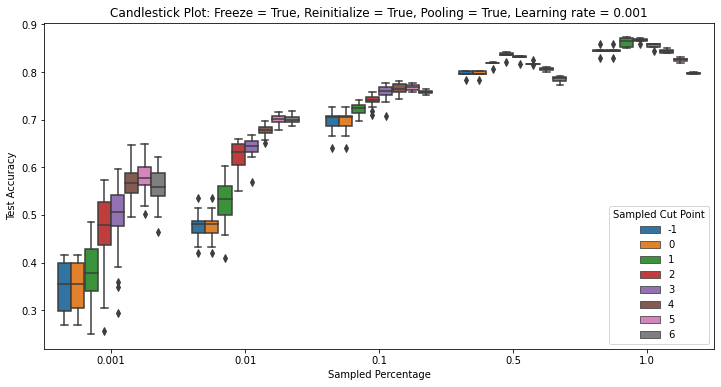

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combining both datasets for comparative analysis
# df_combined = pd.DataFrame(results)
df_combined = pd.DataFrame(results_baseline+results[1:])
df_combined = df_combined.sort_values(by=['sampled_percentage', 'sampled_cut_point'])

# Creating boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(x='sampled_percentage', y='test_acc', hue='sampled_cut_point', data=df_combined)
plt.title(f'Candlestick Plot: Freeze = {params["freeze"]}, Reinitialize = {params["reinit"]}, Pooling = {params["use_pooling"]}, Learning rate = {params["lr_fine_tune"]}')
plt.xlabel('Sampled Percentage')
plt.ylabel('Test Accuracy')
plt.legend(title='Sampled Cut Point')
plt.show()

In [14]:
params_tmp = copy.deepcopy(params)
del params_tmp["device"]
params_tmp["activation_function"] = str(params_tmp["activation_function"])


In [15]:
params_tmp

{'depth': 6,
 'num_channels': 64,
 'activation_function': "<class 'torch.nn.modules.activation.ReLU'>",
 'kernel_size': 3,
 'lr_pretrain': 0.001,
 'lr_fine_tune': 0.001,
 'num_train': 10,
 'early_stop_patience': 5,
 'save_best': False,
 'save_checkpoints': False,
 'is_cnn': True,
 'is_debug': False,
 'classification_report_flag': False,
 'batch_size': 64,
 'pre_train_classes': [5, 6, 7, 8, 9],
 'fine_tune_classes': [2, 3, 0, 1],
 'val_split': 0.1,
 'num_workers': 0,
 'generate_dataset_seed': 42,
 'use_pooling': True,
 'pooling_every_n_layers': 2,
 'pooling_stride': 2,
 'freeze': True,
 'reinit': True,
 'reinit_both_dense': True,
 'truncate': False}

In [4]:
results

[{'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': 0,
  'repeat': 0,
  'train_acc': 0.75,
  'test_acc': 0.29875},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': 0,
  'repeat': 1,
  'train_acc': 0.8125,
  'test_acc': 0.337},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': 0,
  'repeat': 2,
  'train_acc': 0.5,
  'test_acc': 0.29075},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': 0,
  'repeat': 3,
  'train_acc': 0.625,
  'test_acc': 0.385},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': 0,
  'repeat': 4,
  'train_acc': 0.375,
  'test_acc': 0.269},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': 0,
  'repeat': 5,
  'train_acc': 0.5625,
  'test_acc': 0.30775},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': 0,
  'repeat': 6,
  'train_acc': 0.8125,
  'test_acc': 0.408},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': 0,
  're

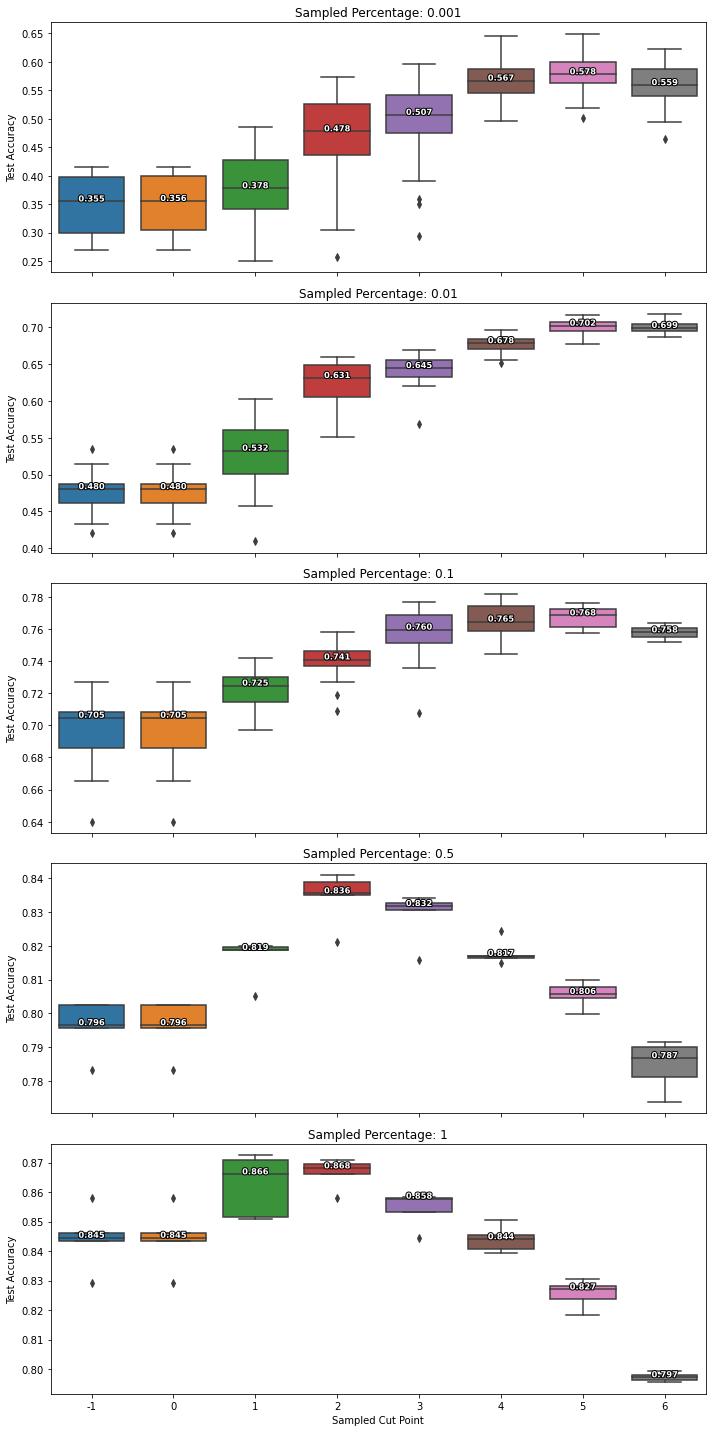

In [18]:
from matplotlib import patheffects
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combining the baseline and results data into a single DataFrame
df_combined = pd.DataFrame(results_baseline + results[1:])

# Assuming 'percentages' is a list of unique percentages you want to consider
unique_percentages = df_combined['sampled_percentage'].unique()
unique_percentages = [perc for perc in unique_percentages if perc in percentages]
unique_percentages =  [0.001, 0.01, 0.1, 0.5, 1]

n_percentages = len(unique_percentages)

# Creating subplots for each data percentage
fig, axes = plt.subplots(nrows=n_percentages, ncols=1, figsize=(10, 20), sharex=True)

# Ensure axes is always an array
if n_percentages == 1:
    axes = [axes]

for i, percentage in enumerate(sorted(unique_percentages)):
    # Filtering data for each percentage
    df_subset = df_combined[df_combined['sampled_percentage'] == percentage]
    
    # Creating a boxplot for the current percentage
    sns.boxplot(x='sampled_cut_point', y='test_acc', data=df_subset, ax=axes[i])
    axes[i].set_title(f'Sampled Percentage: {percentage}')
    axes[i].set_xlabel('Sampled Cut Point' if i == n_percentages - 1 else '')
    axes[i].set_ylabel('Test Accuracy')

    # Annotating each boxplot with the median value
    medians = df_subset.groupby(['sampled_cut_point'])['test_acc'].median().sort_index()
    for j, median in enumerate(medians):
        text = axes[i].text(j, median, f'{median:.3f}', 
                            horizontalalignment='center', size='small', color='white', weight='semibold')
        text.set_path_effects([patheffects.withStroke(linewidth=2, foreground="black")])

plt.tight_layout()
plt.show()


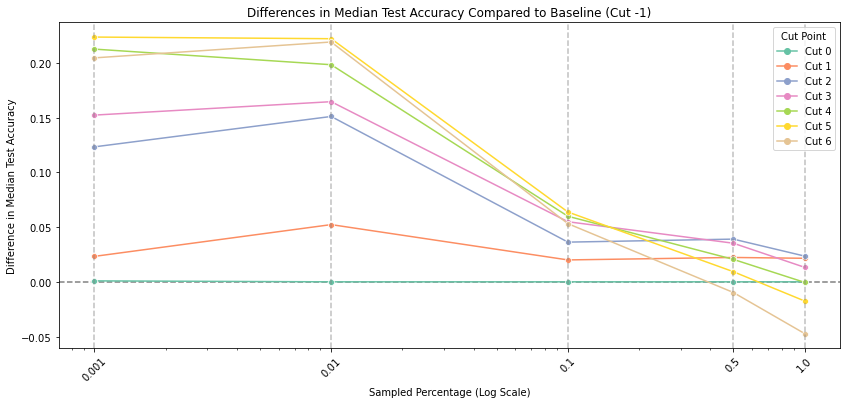

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_combined is your original DataFrame

# Grouping by sampled_percentage, sampled_cut_point and calculating medians
medians_by_cut = df_combined.groupby(['sampled_percentage', 'sampled_cut_point'])['test_acc'].median().reset_index()

# Pivoting the table for easier calculation of differences
pivot_medians = medians_by_cut.pivot(index='sampled_percentage', columns='sampled_cut_point', values='test_acc')

# Identifying all unique cut points except for the baseline (-1)
cut_points = [col for col in pivot_medians.columns if col != -1]

# Calculating differences from baseline for each cut point
for cut in cut_points:
    pivot_medians[f'diff_cut_{cut}'] = pivot_medians[cut] - pivot_medians[-1]

# Resetting index to make 'sampled_percentage' a column
pivot_medians.reset_index(inplace=True)

# Removing rows with NaN values in the new difference columns
pivot_medians.dropna(subset=[f'diff_cut_{cut}' for cut in cut_points], inplace=True)

# Plot setup
plt.figure(figsize=(14, 6))
palette = sns.color_palette("Set2", len(cut_points))  # Setting palette based on number of cut points
plt.title('Differences in Median Test Accuracy Compared to Baseline (Cut -1)')
plt.xlabel('Sampled Percentage (Log Scale)')
plt.ylabel('Difference in Median Test Accuracy')
plt.axhline(0, color='gray', linestyle='--')  # Reference line at zero

for i, cut in enumerate(cut_points):
    sns.lineplot(x='sampled_percentage', y=f'diff_cut_{cut}', data=pivot_medians, marker='o', color=palette[i])

# Adding vertical dashed lines for each sampled percentage
for percentage in pivot_medians['sampled_percentage'].unique():
    plt.axvline(percentage, color='gray', linestyle='--', alpha=0.5)

plt.xscale('log')
plt.xticks(pivot_medians['sampled_percentage'], labels=pivot_medians['sampled_percentage'], rotation=45)

# Custom legend
legend_labels = [f'Cut {cut}' for cut in cut_points]
plt.legend(title='Cut Point', labels=legend_labels, handles=[plt.Line2D([0], [0], color=palette[i], marker='o') for i in range(len(cut_points))])

plt.show()


In [13]:
dataloader_wrapped.update_phase('finetune')

# Reduce the dataset
train_loader_reduced = reduce_dataset(dataloader_wrapped.train_loader, 0.01, seed=0)
dataset_namespace_new = SimpleNamespace(train_loader=train_loader_reduced, test_loader=dataloader_wrapped.test_loader, val_loader=dataloader_wrapped.val_loader)
torch.manual_seed(0) # because in the cut function we reinitialize some layers too (at least the dense layers)

# Copy and then cut the model - we already deepcopy it in the function: pretrained_model
model_new = cut_custom_cnn_model(pretrained_model, cut_point=6, params=params, output_dim=dataloader_wrapped.output_dim)
model_new.to(device)

# Train and evaluate
trainer = Trainer(model_new, dataset_namespace_new, params['lr_fine_tune'], params)
train_acc, test_acc, effective_epochs, checkpoints = trainer.train(verbose=0)
print(f"Training Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

KeyboardInterrupt: 

In [132]:
def compute_class_agnostic_gradients(model, dataloader, device, layers):
    model.eval()
    gradients = {layer: 0 for layer in layers}

    for inputs, _ in dataloader:
        inputs = inputs.to(device)
        inputs.requires_grad_()  # Enable gradient tracking for inputs

        outputs = model(inputs)
        if outputs.grad_fn is None:
            print("No grad_fn found for the outputs, check model's forward pass.")

        for i in range(outputs.shape[1]):  # Loop over each class
            model.zero_grad()
            class_score = outputs[:, i].sum()
            class_score.backward(retain_graph=True)

            for name, layer in model.named_modules():
                if name in layers:
                    if hasattr(layer, 'weight') and layer.weight.grad is not None:
                        gradients[name] += layer.weight.grad.abs().sum().item()  # Aggregate gradients
                        #print(f"Non-zero gradients found in {name}")
                    else:
                        print(f"No gradients or no weight attribute in {name}")

    # Normalize by the number of classes and samples
    num_samples = len(dataloader.dataset)
    num_classes = outputs.shape[1]
    normalized_gradients = {layer: gradients[layer] / (num_samples * num_classes) for layer in layers}

    return normalized_gradients

def set_grad_enabled(model, layers, enabled=True):
    for name, param in model.named_parameters():
        if any(name.startswith(layer) for layer in layers):
            param.requires_grad_(enabled)

layers = ['conv0', 'conv1', 'conv3', 'conv4', 'conv5']  # Specify the layers you're interested in

# Enable gradient tracking for analysis
set_grad_enabled(model_new, layers, enabled=True)

# Now compute the gradients
gradients = compute_class_agnostic_gradients(model_new, dataloader_wrapped.test_loader, device, layers)

# After computing the gradients, disable gradient tracking to restore the original state
set_grad_enabled(model_new, layers, enabled=False)


# Print the gradient results
for layer, grad in gradients.items():
    print(f"Layer: {layer}, Gradient Magnitude: {grad}")

Layer: conv0, Gradient Magnitude: 55.14774205186632
Layer: conv1, Gradient Magnitude: 134.78887331814235
Layer: conv3, Gradient Magnitude: 99.1263495686849
Layer: conv4, Gradient Magnitude: 156.5043659939236
Layer: conv5, Gradient Magnitude: 189.4167162543403


In [133]:
def print_gradient_results(gradients):
    print("Class-Agnostic Gradient Analysis Results:\n")
    print("{:<15} {:<15}".format('Layer', 'Gradient Magnitude'))
    print("-" * 30)

    for layer, gradient in gradients.items():
        print("{:<15} {:<15}".format(layer, round(gradient, 5)))

# Example usage
print_gradient_results(gradients)


Class-Agnostic Gradient Analysis Results:

Layer           Gradient Magnitude
------------------------------
conv0           55.14774       
conv1           134.78887      
conv3           99.12635       
conv4           156.50437      
conv5           189.41672      


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

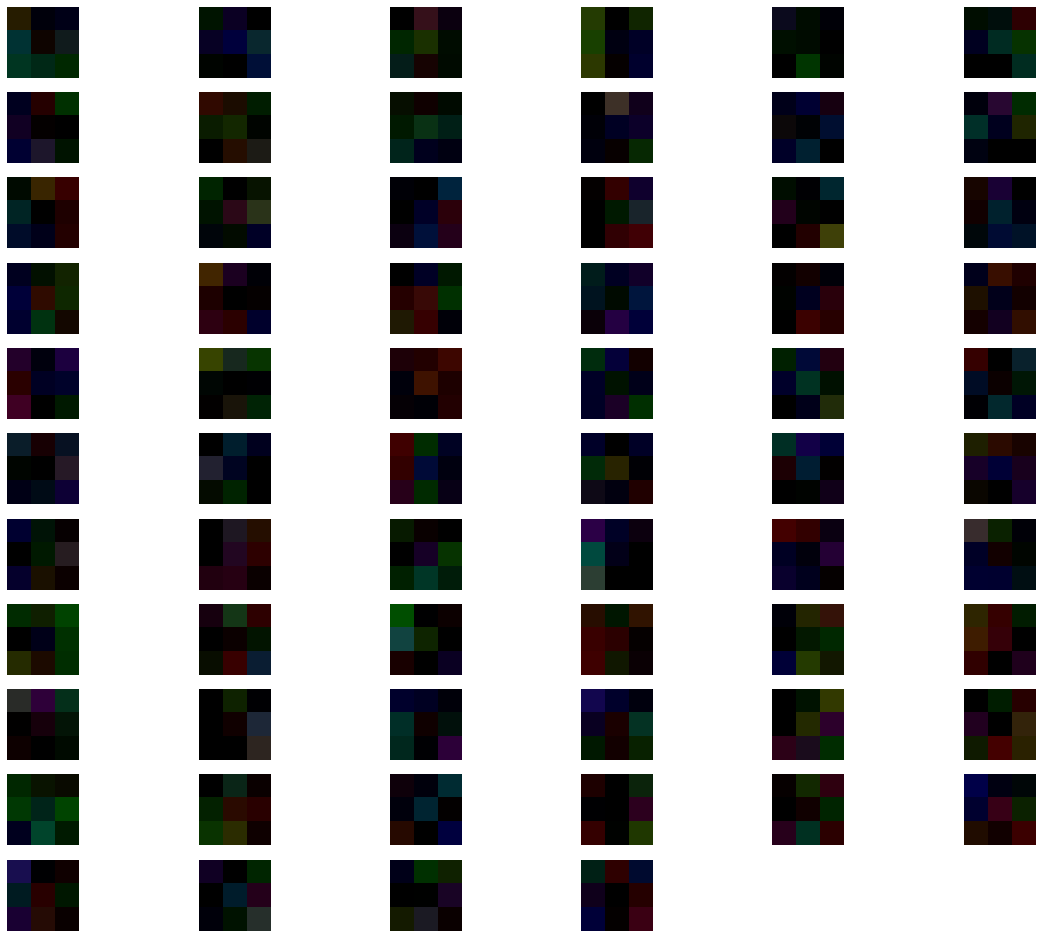

In [134]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_filters(layer):
    # Assuming layer is a Conv2D layer
    filters = layer.weight.data.cpu()  # Move the tensor to CPU
    n_filters = filters.shape[0]

    plt.figure(figsize=(20, 17))
    for i in range(n_filters):
        ax = plt.subplot(n_filters // 6 + 1, 6, i + 1)
        plt.imshow(filters[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()

# Example usage: Visualize filters of the first conv layer
visualize_filters(model_new.conv0)  # Replace with your layer name


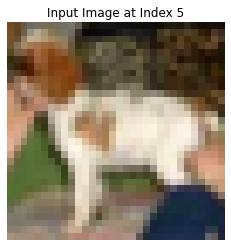

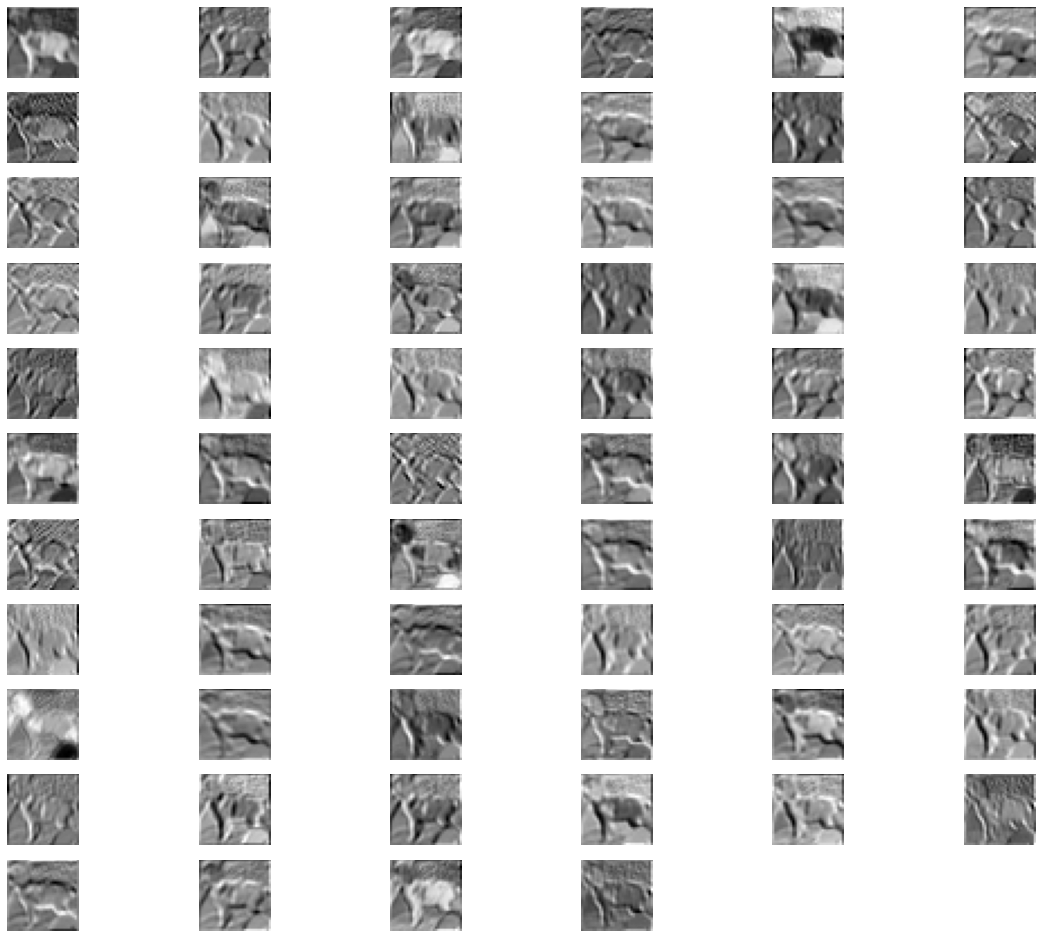

In [169]:
import torch
import matplotlib.pyplot as plt

def tensor_to_image(tensor):
    # Move the tensor to CPU and convert to numpy
    tensor = tensor.to('cpu').detach()

    # Convert to numpy and scale to range [0, 1]
    numpy_image = tensor.numpy().transpose((1, 2, 0))
    numpy_image = numpy_image - numpy_image.min()
    numpy_image = numpy_image / numpy_image.max()
    return numpy_image

def get_activations(model, layer, input_image):
    # Register a hook to extract activations
    activations = []
    hook = layer.register_forward_hook(lambda m, i, o: activations.append(o))
    
    # Forward pass
    model(input_image)
    
    # Remove the hook
    hook.remove()
    
    return activations[0]

def visualize_activations(activations):
    n_activations = activations.shape[1]

    plt.figure(figsize=(20, 17))
    for i in range(n_activations):
        ax = plt.subplot(n_activations // 6 + 1, 6, i + 1)
        plt.imshow(activations[0, i].detach().cpu().numpy(), cmap='gray')
        ax.axis('off')
    plt.show()

"""# Load and preprocess the first input image from the test loader
first_batch = next(iter(dataloader_wrapped.test_loader))
input_image, _ = first_batch
input_image = input_image.to(device)

# Ensure input is in the correct format
input_image = input_image[0].unsqueeze(0)  # Get the first image and add a batch dimension

# Visualize the input image
plt.imshow(tensor_to_image(input_image[0]))
plt.title("Input Image")
plt.axis('off')
plt.show()
"""


def get_image_at_index(dataloader, index):
    count = 0
    for images, _ in dataloader:
        for image in images:
            if count == index:
                return image
            count += 1
    raise IndexError("Index out of range")

# Specify the index of the image you want to visualize
image_index = 5  # Replace with your desired index

# Get the image at the specified index and add a batch dimension
input_image = get_image_at_index(dataloader_wrapped.test_loader, image_index).unsqueeze(0).to(device)

# Visualize the input image
plt.imshow(tensor_to_image(input_image.squeeze()))  # squeeze to remove batch dimension for visualization
plt.title(f"Input Image at Index {image_index}")
plt.axis('off')
plt.show()

# Example usage
activations = get_activations(model_new, model_new.conv0, input_image)
visualize_activations(activations)




In [208]:
def modified_forward(model, input, layers_to_extract):
    activations = {}
    x = input
    for name, layer in model.named_children():
        if isinstance(layer, torch.nn.Conv2d) or isinstance(layer, torch.nn.ReLU) or isinstance(layer, torch.nn.AvgPool2d):
            x = layer(x)
            if name in layers_to_extract:
                activations[name] = x
        elif isinstance(layer, torch.nn.Linear):
            # Flatten x before passing to a linear layer
            x = x.view(x.size(0), -1)
            break
    return activations


def get_layer_activations(model, dataloader, device, layers_to_extract):
    original_forward = model.forward
    model.forward = lambda input: modified_forward(model, input, layers_to_extract)

    collected_activations = {layer: [] for layer in layers_to_extract}

    model.eval()
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            layer_outputs = model(inputs)
            for layer in layers_to_extract:
                collected_activations[layer].append(layer_outputs[layer].detach())

    # Restore original forward function
    model.forward = original_forward

    # Concatenate all batches
    for layer in collected_activations:
        collected_activations[layer] = torch.cat(collected_activations[layer], dim=0)

    return collected_activations

# Example usage
layers_to_extract = ['conv0', 'conv1', 'conv2', 'conv3', 'conv4', 'conv5']  # Specify layer names
activations = get_layer_activations(model_new, dataloader_wrapped.test_loader, device, layers_to_extract)


In [219]:
def reshape_activations(activations):
    reshaped_activations = {}
    for layer, act in activations.items():
        # Flatten each activation
        n_samples = act.size(0)
        n_features = np.prod(act.size()[1:])
        reshaped_activations[layer] = act.view(n_samples, n_features)
    return reshaped_activations

reshaped_activations = reshape_activations(activations)

from sklearn.decomposition import PCA

def reduce_dimensions(activations, n_components=50):
    reduced_activations = {}
    activationss = {}
    for layer, act in activations.items():
        pca = PCA(n_components=n_components)
        reduced_activations[layer] = pca.fit_transform(act.cpu())
        activationss[layer] = act.cpu()
    return reduced_activations, activationss

reduced_activations, activations = reduce_dimensions(reshaped_activations)

In [221]:
from sklearn.neighbors import KernelDensity

def apply_kde(activations):
    kde_models = {}
    for layer, act in activations.items():
        kde = KernelDensity(kernel='gaussian', bandwidth=0.5)
        kde.fit(act)
        kde_models[layer] = kde
    return kde_models

kde_models = apply_kde(reduced_activations)

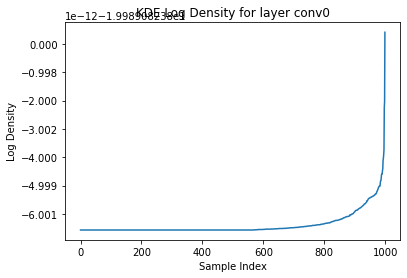

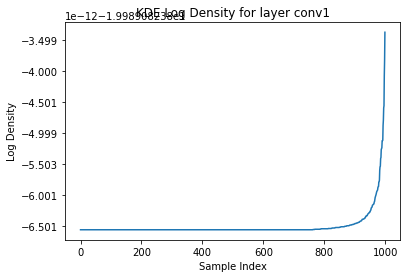

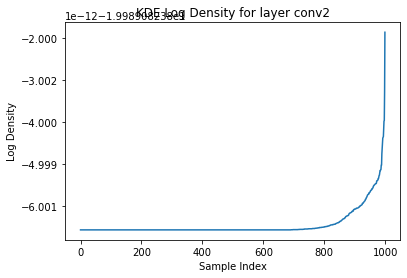

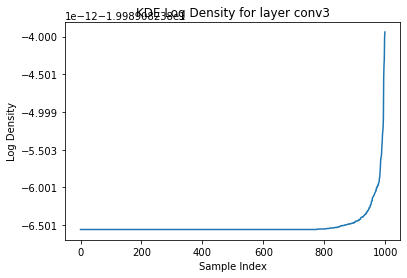

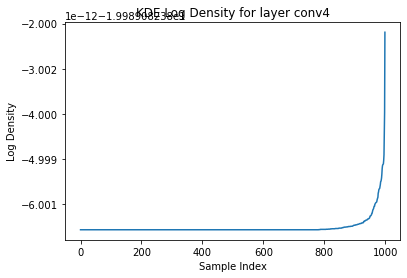

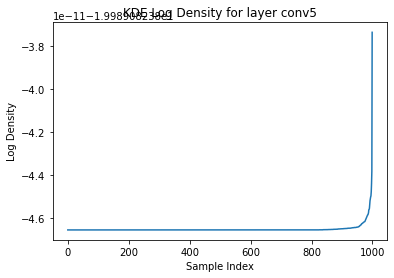

In [226]:
def plot_kde_samples(kde_models, activations, n_samples=1000):
    for layer, kde in kde_models.items():
        # Randomly sample points from activations and move them to CPU
        sampled_indices = np.random.choice(activations[layer].shape[0], n_samples, replace=False)
        sampled_activations = activations[layer][sampled_indices]

        # Compute log density for these points
        log_density = kde.score_samples(sampled_activations)

        plt.figure()
        plt.plot(np.sort(log_density))
        plt.title(f'KDE Log Density for layer {layer}')
        plt.xlabel('Sample Index')
        plt.ylabel('Log Density')
        plt.show()

plot_kde_samples(kde_models, reduced_activations)


In [32]:
import pandas as pd
from scipy.stats import wilcoxon
import numpy as np

# Assuming df_combined is your original DataFrame
df_differences = df_combined[df_combined['sampled_cut_point'] != -1]
df_combined.sort_values(by=['sampled_percentage', 'sampled_cut_point'], inplace=True)

median_baseline = df_combined[df_combined['sampled_cut_point'] == -1].groupby('sampled_percentage')['test_acc'].median()
df_with_baseline = df_combined.merge(median_baseline, on='sampled_percentage', suffixes=('', '_baseline'))
df_with_baseline['diff_to_baseline'] = df_with_baseline['test_acc'] - df_with_baseline['test_acc_baseline']
df_differences = df_with_baseline[df_with_baseline['sampled_cut_point'] != -1]

In [20]:
import pandas as pd
from scipy.stats import wilcoxon
import numpy as np

# Assuming df_combined is your original DataFrame
df_differences = df_combined[df_combined['sampled_cut_point'] != -1]

def perform_wilcoxon_test(group, cut_point_1, cut_point_2):
    data_1 = group[group['sampled_cut_point'] == cut_point_1]['test_acc']
    data_2 = group[group['sampled_cut_point'] == cut_point_2]['test_acc']

    # Ensure equal length by trimming or padding
    min_len = min(len(data_1), len(data_2))
    data_1, data_2 = data_1[:min_len], data_2[:min_len]

    stat, p_value = wilcoxon(data_1, data_2)
    return stat, p_value

# Perform pairwise comparison for each sampled_percentage
wilcoxon_pairwise_results = []

for percentage in df_differences['sampled_percentage'].unique():
    group = df_differences[df_differences['sampled_percentage'] == percentage]
    cut_points = group['sampled_cut_point'].unique()

    for i in range(len(cut_points)):
        for j in range(i + 1, len(cut_points)):
            stat, p_value = perform_wilcoxon_test(group, cut_points[i], cut_points[j])
            wilcoxon_pairwise_results.append({
                'sampled_percentage': percentage,
                'cut_point_1': cut_points[i],
                'cut_point_2': cut_points[j],
                'statistic': stat,
                'p_value': p_value
            })

# Converting the results to a DataFrame
df_wilcoxon_pairwise = pd.DataFrame(wilcoxon_pairwise_results)


/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [21]:
import pandas as pd

# Assuming df_wilcoxon_pairwise and df_differences are defined as before

# Step 1: Aggregate Test Accuracy and Initialize Rankings
median_accuracy = df_differences.groupby(['sampled_percentage', 'sampled_cut_point'])['test_acc'].median()

rankings = {percentage: {} for percentage in median_accuracy.index.get_level_values(0).unique()}
for (percentage, cut_point), accuracy in median_accuracy.items():
    rankings[percentage][cut_point] = {'median_accuracy': accuracy, 'rank': None, 'group': set([cut_point])}

# Step 2: Group Cuts Based on Statistical Significance
alpha = 0.05  # Significance level

for percentage, cuts_info in rankings.items():
    for cut1, info1 in cuts_info.items():
        for cut2, info2 in cuts_info.items():
            if cut1 != cut2:
                wilcoxon_row = df_wilcoxon_pairwise[
                    (df_wilcoxon_pairwise['sampled_percentage'] == percentage) & 
                    ((df_wilcoxon_pairwise['cut_point_1'] == cut1) & (df_wilcoxon_pairwise['cut_point_2'] == cut2) |
                     (df_wilcoxon_pairwise['cut_point_1'] == cut2) & (df_wilcoxon_pairwise['cut_point_2'] == cut1))
                ]
                if not wilcoxon_row.empty and wilcoxon_row.iloc[0]['p_value'] > alpha:
                    # Merge groups if not significantly different
                    info1['group'].update(info2['group'])
                    for cut in info2['group']:
                        info1['group'].update(rankings[percentage][cut]['group'])
                    for cut in info1['group']:
                        rankings[percentage][cut]['group'] = info1['group']

# Step 3: Assign Ranks with Ties
for percentage, cuts_info in rankings.items():
    sorted_groups = sorted({frozenset(info['group']) for cut, info in cuts_info.items()}, key=lambda x: min(median_accuracy[percentage, cut] for cut in x), reverse=True)
    rank = 1
    for group in sorted_groups:
        for cut in group:
            rankings[percentage][cut]['rank'] = rank
        rank += len(group)

# Convert rankings and median accuracies to a DataFrame for easier visualization
df_rankings = pd.DataFrame([(percentage, cut, data['rank'], data['median_accuracy']) for percentage, cuts_info in rankings.items() for cut, data in cuts_info.items()],
                           columns=['sampled_percentage', 'sampled_cut_point', 'rank', 'median_accuracy'])

df_rankings


,sampled_percentage,sampled_cut_point,rank,median_accuracy
0,0.001,0,6,0.355625
1,0.001,1,6,0.378000
2,0.001,2,5,0.478000
3,0.001,3,4,0.507000
4,0.001,4,1,0.567250
5,0.001,5,1,0.578250
6,0.001,6,1,0.559250
7,0.010,0,7,0.480250
8,0.010,1,6,0.532500
9,0.010,2,5,0.631250


In [22]:
df_combined

,lr,sampled_percentage,sampled_cut_point,repeat,train_acc,test_acc
0,0.001,0.001,-1,0,0.750000,0.29875
1,0.001,0.001,-1,1,0.812500,0.33700
2,0.001,0.001,-1,2,0.500000,0.29075
3,0.001,0.001,-1,3,0.625000,0.38500
4,0.001,0.001,-1,4,0.375000,0.26900
...,...,...,...,...,...,...
634,0.001,1.000,6,0,0.830354,0.79800
635,0.001,1.000,6,1,0.830465,0.79925
636,0.001,1.000,6,2,0.832860,0.79550
637,0.001,1.000,6,3,0.833361,0.79625


In [23]:
median_baseline = df_combined[df_combined['sampled_cut_point'] == -1].groupby('sampled_percentage')['test_acc'].median()
df_with_baseline = df_combined.merge(median_baseline, on='sampled_percentage', suffixes=('', '_baseline'))
df_with_baseline['diff_to_baseline'] = df_with_baseline['test_acc'] - df_with_baseline['test_acc_baseline']
df_differences = df_with_baseline[df_with_baseline['sampled_cut_point'] != -1]

from scipy.stats import wilcoxon
import numpy as np

def perform_wilcoxon_test(data, baseline_median, cut_point):
    cut_data = data[data['sampled_cut_point'] == cut_point]['test_acc']
    baseline_data = np.full(len(cut_data), baseline_median)  # Creating an array of baseline values

    # Performing the Wilcoxon signed-rank test
    stat, p_value = wilcoxon(cut_data, baseline_data)
    return stat, p_value

# Performing the test for each cut point and sampled percentage
wilcoxon_corrected_results = []
for percentage in df_differences['sampled_percentage'].unique():
    baseline_median = median_baseline[percentage]
    for cut_point in df_differences[df_differences['sampled_cut_point'] != -1]['sampled_cut_point'].unique():
        subset = df_differences[(df_differences['sampled_percentage'] == percentage) & (df_differences['sampled_cut_point'] == cut_point)]
        stat, p_value = perform_wilcoxon_test(subset, baseline_median, cut_point)
        wilcoxon_corrected_results.append({
            'sampled_percentage': percentage,
            'sampled_cut_point': cut_point,
            'statistic': stat,
            'p_value': p_value
        })

# Converting the results to a DataFrame for easier visualization
df_wilcoxon_corrected = pd.DataFrame(wilcoxon_corrected_results)


# add a columns saying if the p-value is significant or not
df_wilcoxon_corrected['is_significant'] = df_wilcoxon_corrected['p_value'] < 0.05
df_wilcoxon_corrected

/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/opt/anaconda/lib/python3.7/site-packages/s

,sampled_percentage,sampled_cut_point,statistic,p_value,is_significant
0,0.001,0,122.5,6.373130e-01,False
1,0.001,1,108.0,1.484796e-01,False
2,0.001,2,16.0,1.007318e-05,True
3,0.001,3,7.0,1.132488e-06,True
4,0.001,4,0.0,5.960464e-08,True
5,0.001,5,0.0,5.960464e-08,True
6,0.001,6,0.0,5.960464e-08,True
7,0.010,0,123.5,4.489411e-01,False
8,0.010,1,21.0,2.664328e-05,True
9,0.010,2,0.0,5.960464e-08,True
